In [186]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
import xgboost as xgb
from sklearn.metrics import mean_absolute_error
from scipy.interpolate import CubicSpline, interp1d
from scipy.linalg import svd
from tqdm import tqdm
from statsmodels.tsa.api import VAR
from statsmodels.tsa.statespace.varmax import VARMAX
from statsmodels.tsa.statespace.sarimax import SARIMAX 
from numpy.fft import rfft, rfftfreq
from scipy.signal import argrelmax, stft, periodogram
# import tensorflow as tf
# from tensorflow.keras.models import Sequential
# from tensorflow.keras.layers import LSTM, Dense
from sklearn.preprocessing import MinMaxScaler
import matplotlib.ticker as ticker
import seaborn as sns
from statsmodels.tsa.stattools import pacf, adfuller, acf, levinson_durbin
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.tsa.ar_model import AutoReg
from scipy.linalg import cho_solve, cho_factor
import warnings
from scipy.ndimage import gaussian_filter1d
from statsmodels.tsa.arima.model import ARIMA
import scipy.interpolate
# from tensorflow.keras.layers import Input, Dense
# from tensorflow.keras.models import Model
from prophet import Prophet


warnings.simplefilter(action='ignore', category="ValueWarning")

In [187]:
def fig_ax(nrows=1, figsize=(15, 3)):
    return plt.subplots(nrows=nrows, figsize=(figsize[0], figsize[1] * nrows))

# 1. Explore Data

In [188]:
data = pd.read_csv('X_train.csv')
data.set_index("Horodate", inplace=True)
data.drop(columns=["holed_192"], inplace=True)

In [189]:
data_train = pd.read_csv('y_train.csv')
data_train.set_index("Horodate", inplace=True)
data_train.dropna(axis=1, inplace=True)
data_train.isnull().sum().max() # Check qu'il n'y a aucune donnée manquante dans ce dataframe

0

In [5]:
for col in data_train.columns:
    if data_train[col].isnull().sum() != 0:
        print(col)

### ---

In [190]:
df_test = pd.read_csv('X_test.csv')
df_test.set_index('Horodate', inplace=True)

### ---

In [191]:
feature_TS_train = [col for col in data.columns if 'holed' not in col]
holed_T_train  = [col for col in data.columns if 'holed' in col]
feature_TS_test = [col for col in df_test.columns if 'holed' not in col]
holed_T_test  = [col for col in df_test.columns if 'holed' in col]

df_test_complete = df_test.loc[:,feature_TS_test].dropna(axis=1).copy()
df_test_missing = df_test.loc[:,holed_T_test].copy()
complete_TS = data.loc[:,feature_TS_train].copy()
TS_missing = data.loc[:,holed_T_train].copy()
# common_columns = complete_TS.columns.intersection(df_test_complete.columns)
# complete_TS = complete_TS[common_columns]
# df_test_complete = df_test_complete[common_columns]

In [192]:
# Séparer les séries en 80% train et 20% test
train_series, test_series = train_test_split(TS_missing.columns, test_size=0.2, random_state=42)

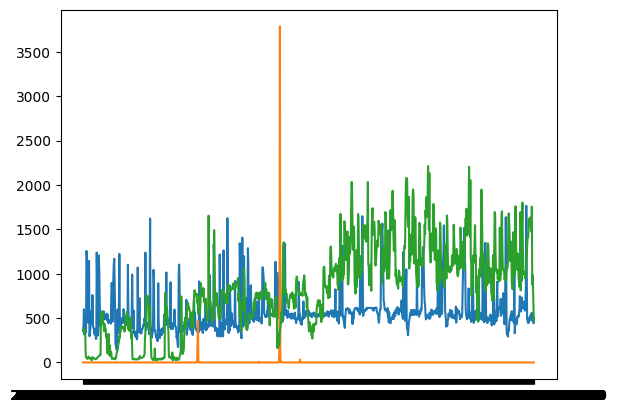

In [9]:
plt.plot(data.iloc[:,0])
plt.plot(data.iloc[:,1])
plt.plot(data.iloc[:,2])

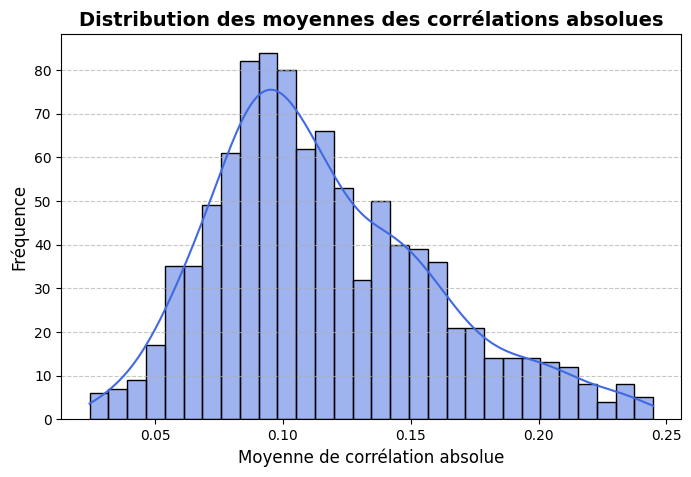

In [56]:
corr_test = data.sample(n=1000, axis=1).corr()
corr_mean = corr_test.abs().mean()

# Création de l'histogramme avec une meilleure visualisation
plt.figure(figsize=(8, 5))
sns.histplot(corr_mean, bins=30, kde=True, color="royalblue", edgecolor="black")

# Ajout des titres et labels
plt.title("Distribution des moyennes des corrélations absolues", fontsize=14, fontweight="bold")
plt.xlabel("Moyenne de corrélation absolue", fontsize=12)
plt.ylabel("Fréquence", fontsize=12)

# Ajout d'une grille
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.savefig("plots_raport/histo_correlations.png", dpi=500)
# Affichage du plot
plt.show()

In [15]:
col = -1
data.iloc[:,col][data.iloc[:,col].isna()].shape[0]

219

In [16]:
n = 10
data.iloc[:,[i for i in range(n)]+[-1]].corr().iloc[:-1,-1].dropna()

5423908671    0.056926
2568793410    0.011136
8310762594    0.262633
6235194807   -0.125170
423895617     0.232911
193845276     0.044566
216589743     0.192563
218753964    -0.259729
1794650328    0.062698
9253476180    0.014752
Name: holed_1000, dtype: float64

In [18]:
n = 1000
data.iloc[:,[i for i in range(n)]+[-1]].corr().iloc[:-1,-1].dropna().abs().max()

np.float64(0.32969211548761196)

In [19]:
n = 100
data.iloc[:,[i for i in range(n)]+[-1]].corr().iloc[:-1,-1].dropna().abs().argmax()

np.int64(2)

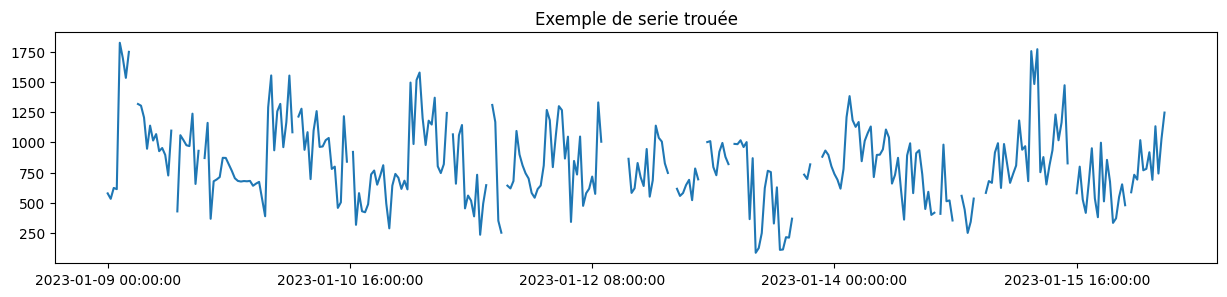

In [54]:
fig, ax = fig_ax()
plt.plot(TS_missing.iloc[:350,0])
plt.title("Exemple de serie trouée")
ax.xaxis.set_major_locator(ticker.MaxNLocator(nbins=6))
plt.savefig("plots_raport/exemple_serie_trouée.png",dpi=500)
plt.show()

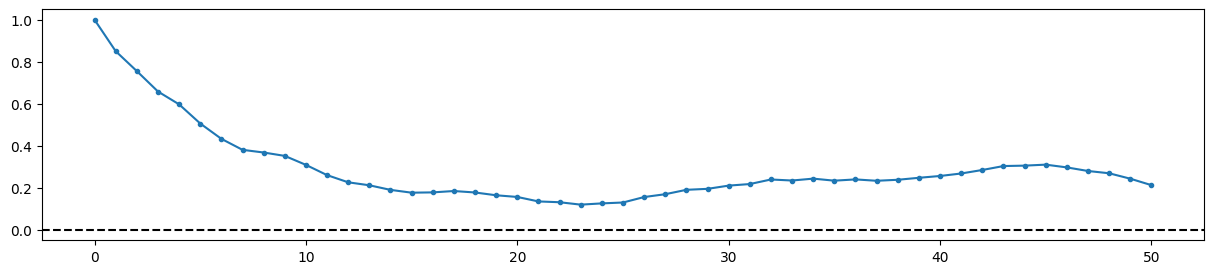

In [374]:
fig, ax = fig_ax()
ax.plot(acf(TS_missing.iloc[:,3].dropna(), nlags=50, fft=True), ".-")
ax.axhline(0, ls="--", color="k")
plt.show()

0it [00:00, ?it/s]/Users/Mel/Desktop/Ecole_Inge/MFD/ML/Time_series_for_finance/MFD_ML_project/lib/python3.10/site-packages/statsmodels/tsa/stattools.py:702: RuntimeWarning: invalid value encountered in divide
  acf = avf[: nlags + 1] / avf[0]
50it [00:00, 5191.61it/s]


OK


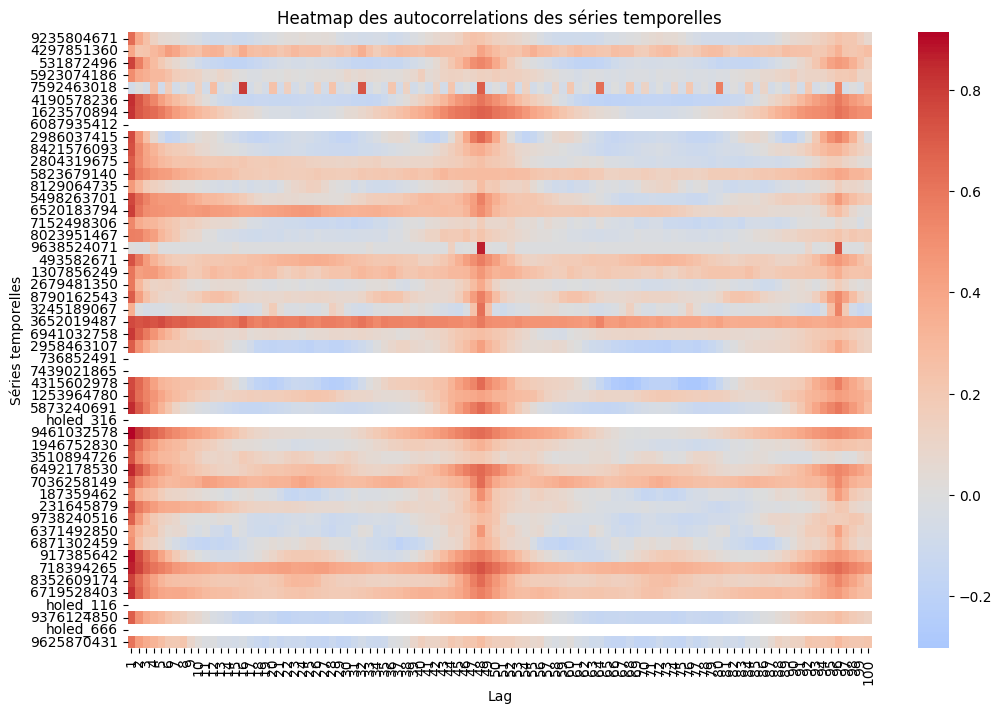

In [55]:
np.random.seed(42)
n_series = 50
sample_data = data.sample(n=n_series,axis=1).copy()

# Calcul des autocorrelations à différents lags
lags = 100  # Nombre de lags à afficher
autocorr_matrix = np.zeros((n_series, lags))

for i, col in tqdm(enumerate(sample_data.columns)):
    autocorr_matrix[i, :] = acf(sample_data.loc[:,col], nlags=lags, fft=True)[1:]  # Exclut le lag 0 (corrélation parfaite)
print('OK')
# Plot Heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(autocorr_matrix, cmap="coolwarm", center=0, xticklabels=range(1, lags+1), yticklabels=sample_data.columns)
plt.xlabel("Lag")
plt.ylabel("Séries temporelles")
plt.title("Heatmap des autocorrelations des séries temporelles")
plt.savefig('plots_raport/acf.png',dpi=500)
plt.show()

In [22]:
nan_count_per_column = complete_TS.isnull().sum()
print(nan_count_per_column.max())

nan


In [22]:
FREQUENCY = 49
f, t, Zxx = stft(df_test_complete.iloc[:,1], fs=FREQUENCY, nperseg=1000, noverlap=800)

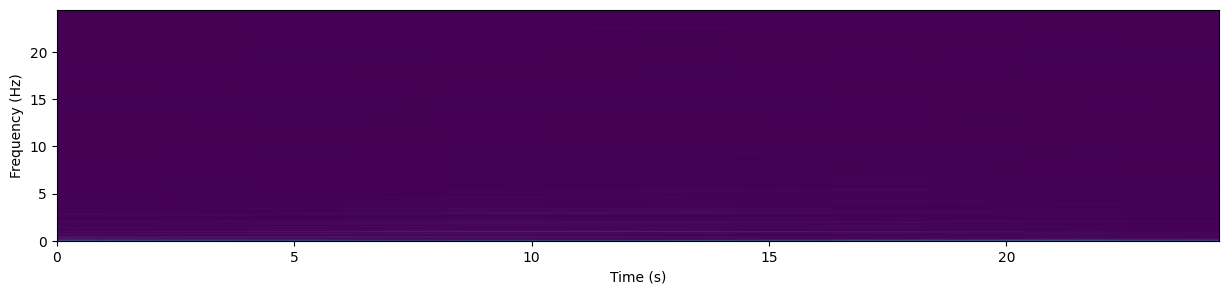

In [23]:
fig, ax = fig_ax()
ax.pcolormesh(t, f, np.abs(Zxx), vmin=0, shading="gouraud")
ax.set_xlabel("Time (s)")
_ = ax.set_ylabel("Frequency (Hz)")

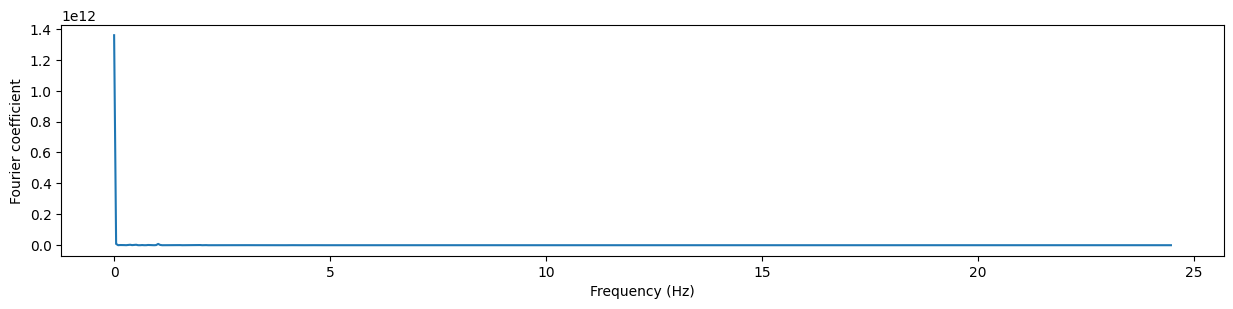

In [25]:
n_samples = df_test_complete.shape[0]
fourier = abs(rfft(df_test_complete.iloc[:,1])) ** 2
freqs = rfftfreq(n=n_samples, d=1.0 / FREQUENCY)

fig, ax = fig_ax()
ax.plot(freqs, fourier)
ax.set_xlabel("Frequency (Hz)")
_ = ax.set_ylabel("Fourier coefficient")

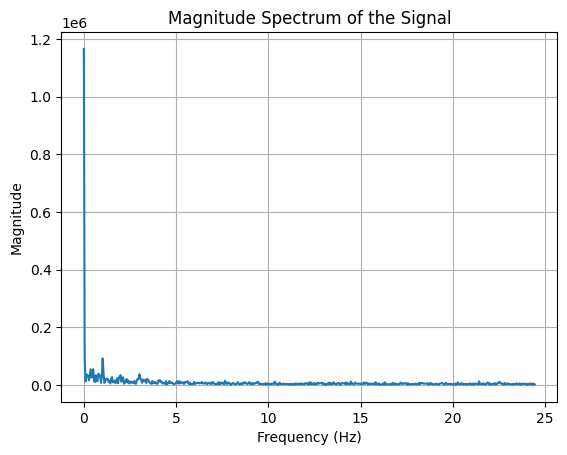

In [28]:
fs = 49
# Compute the DFT of the signal
dft = np.fft.fft(df_test_complete.iloc[:,1])
# Frequency bins
frequencies = np.fft.fftfreq(len(df_test_complete.iloc[:,1]), 1 / fs)

# Plot the magnitude spectrum
plt.plot(frequencies[:len(frequencies) // 2], np.abs(dft)[:len(dft) // 2])
plt.xlabel("Frequency (Hz)")
plt.ylabel("Magnitude")
plt.title("Magnitude Spectrum of the Signal")
plt.grid(True)
plt.show()

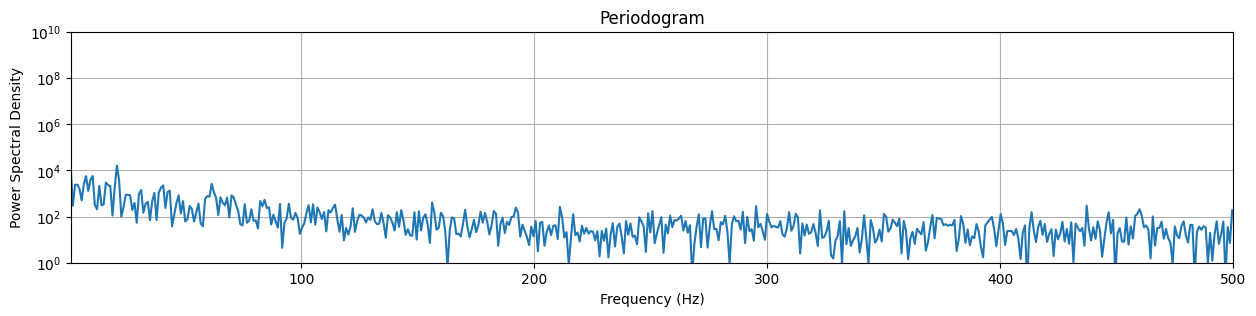

In [31]:
# Compute the periodogram
fig, ax = fig_ax()
frequencies, power_spectrum = periodogram(df_test_complete.iloc[:,1], 1000)

# Plot the periodogram
# plt.figure(figsize=(10, 6))
plt.semilogy(frequencies, power_spectrum)
plt.xlim((1,500))
plt.ylim((10e-1,10e9))
plt.title('Periodogram')
plt.xlabel('Frequency (Hz)')
plt.ylabel('Power Spectral Density')
plt.grid(True)
plt.show()

In [32]:
frequencies[power_spectrum.argmax()]

np.float64(0.946073793755913)

In [319]:
def longest_missing_segment(series):
    """
    Trouve la plus grande portion consécutive de données manquantes (NaN) dans une série temporelle.

    Paramètres :
    - series : array-like (pandas Series ou numpy array), la série temporelle.

    Retourne :
    - max_gap : longueur de la plus grande séquence continue de NaN.
    """
    is_nan = np.isnan(series)  # Masque booléen des NaN
    max_gap = 0  # Longueur max de la séquence de NaN
    current_gap = 0  # Compteur temporaire

    for missing in is_nan:
        if missing:
            current_gap += 1  # Incrémentation si NaN
        else:
            max_gap = max(max_gap, current_gap)  # Mise à jour du max
            current_gap = 0  # Réinitialisation si valeur valide

    # Vérification à la fin (si la série se termine par des NaN)
    max_gap = max(max_gap, current_gap)

    return max_gap

In [43]:
def longest_nan_sequence(series):
    """
    Fonction pour détecter les longueurs des séquences de NaN dans une série.
    
    Paramètre :
    - series : np.array ou pandas.Series

    Retourne :
    - Une liste contenant la taille de chaque patch de NaN.
    """
    nan_lengths = []
    current_length = 0
    
    for value in series:
        if np.isnan(value):
            current_length += 1
        else:
            if current_length > 0:
                nan_lengths.append(current_length)
                current_length = 0
    
    if current_length > 0:  # Ajout du dernier patch si nécessaire
        nan_lengths.append(current_length)
    
    return nan_lengths

In [45]:
gaps = []
for col in TS_missing.columns:
    gaps += longest_nan_sequence(TS_missing[col])

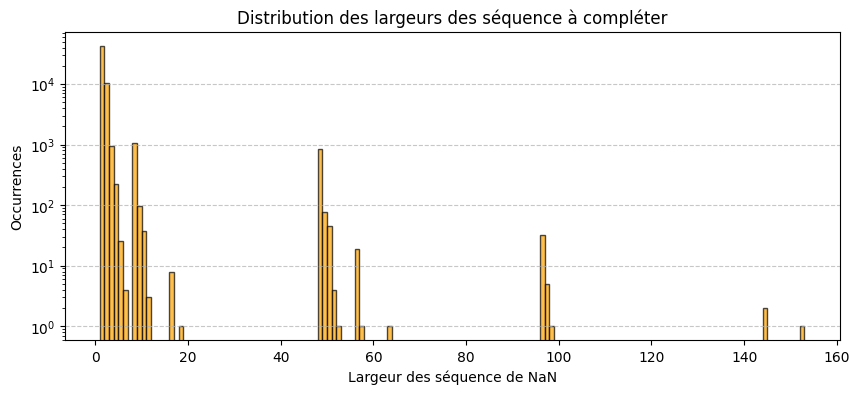

In [53]:
plt.figure(figsize=(10,4))
plt.hist(gaps, bins=range(1, max(gaps)+2), edgecolor='black', alpha=0.7, color='orange')
plt.xlabel("Largeur des séquence de NaN")
plt.ylabel("Occurrences")
plt.title("Distribution des largeurs des séquence à compléter")
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.yscale('log')
plt.savefig('plots_raport/distribution_patch.png', dpi=500)
plt.show()

# Testing Models

## 1. Interpolation

In [825]:
# 📌 Filtrer les colonnes trouées
data_train_interpolate = data_train.reset_index(drop=True)
TS_missing_interpolate = TS_missing.reset_index(drop=True)
columns_holed = [col for col in test_series if 'holed_' in col]

# 📌 Initialiser les DataFrames pour stocker les interpolations
df_cubic = TS_missing_interpolate.copy()
df_spline = TS_missing_interpolate.copy()
df_linear = TS_missing_interpolate.copy()

mae_cubic_total = []
mae_spline_total = []
mae_linear_total = []

# 📌 Boucle sur chaque série trouée
for col in columns_holed:
    # Indices des valeurs connues
    valid_idx = TS_missing_interpolate[col].dropna().index.astype(float)
    
    # Interpolation Cubique
    cubic_interp = interp1d(valid_idx, TS_missing_interpolate[col].dropna(), kind="cubic", fill_value="extrapolate")
    df_cubic[col] = cubic_interp(TS_missing_interpolate.index.astype(float))
    
    # Interpolation Spline
    spline_interp = CubicSpline(valid_idx, TS_missing_interpolate[col].dropna())
    df_spline[col] = spline_interp(TS_missing_interpolate.index.astype(float))
    
    # Interpolation Linéaire
    linear_interp = interp1d(valid_idx,  TS_missing_interpolate[col].dropna(), kind="linear", fill_value="extrapolate")
    df_linear[col] = linear_interp(TS_missing_interpolate.index.astype(float))
    
    # Calcul des erreurs uniquement sur les valeurs manquantes
    missing_idx = TS_missing_interpolate[TS_missing_interpolate[col].isna()].index
    mae_cubic = mean_absolute_error(data_train_interpolate.loc[missing_idx, col], df_cubic.loc[missing_idx, col])
    mae_spline = mean_absolute_error(data_train_interpolate.loc[missing_idx, col], df_spline.loc[missing_idx, col])
    mae_linear = mean_absolute_error(data_train_interpolate.loc[missing_idx, col], df_linear.loc[missing_idx, col])
    
    mae_cubic_total.append(mae_cubic)
    mae_spline_total.append(mae_spline)
    mae_linear_total.append(mae_linear)

# 📌 Afficher les MAE moyennes sur toutes les séries
print(f"📊 MAE Moyenne sur {len(columns_holed)} séries :")
print(f"➡️  Interpolation Cubique  : {np.mean(mae_cubic_total):.4f}")
print(f"➡️  Interpolation Spline   : {np.mean(mae_spline_total):.4f}")
print(f"➡️  Interpolation Linéaire : {np.mean(mae_linear_total):.4f}")

# 📌 Sauvegarde des interpolations
df_cubic.to_csv("results/interpolation_cubic_all.csv")
df_spline.to_csv("results/interpolation_spline_all.csv")
df_linear.to_csv("interpolation_linear_all.csv")

print("✅ Interpolations terminées et fichiers sauvegardés !")

📊 MAE Moyenne sur 200 séries :
➡️  Interpolation Cubique  : 29038.1561
➡️  Interpolation Spline   : 29038.1561
➡️  Interpolation Linéaire : 107.7838
✅ Interpolations terminées et fichiers sauvegardés !


In [826]:
df_linear = df_linear.interpolate(method='linear', axis=0, limit_direction='both')

In [827]:
missing_idx = np.isnan(TS_missing[test_series].values)
mae = mean_absolute_error(data_train[test_series].values[missing_idx], df_linear[test_series].values[missing_idx])
print(mae)

120.23685464615986


In [867]:
def filter_true_sequences(arr: np.ndarray, min_length: int) -> np.ndarray:
    """
    Conserve uniquement les séquences de True d'une longueur donnée dans un tableau numpy 2D,
    en remplaçant les autres valeurs par False. La vérification se fait uniquement sur les colonnes.
    
    :param arr: np.ndarray booléen 2D contenant des True et False
    :param min_length: Longueur minimale des séquences de True à conserver
    :return: Nouveau tableau avec uniquement les séquences valides conservées
    """
    result = np.zeros_like(arr, dtype=bool)
    
    # Parcours des colonnes
    for j in range(arr.shape[1]):
        true_indices = np.where(arr[:, j])[0]  # Indices des True
        if len(true_indices) > 0:
            splits = np.split(true_indices, np.where(np.diff(true_indices) != 1)[0] + 1)  # Séquences continues
            for seq in splits:
                if len(seq) >= min_length:
                    result[seq, j] = True
    
    return result

mae_list = []
for i in range(1,150):
    filtered_tab = filter_true_sequences(missing_idx, i)
    mae = mean_absolute_error(data_train[test_series].values[filtered_tab], df_linear[test_series].values[filtered_tab])
    mae_list.append(mae)

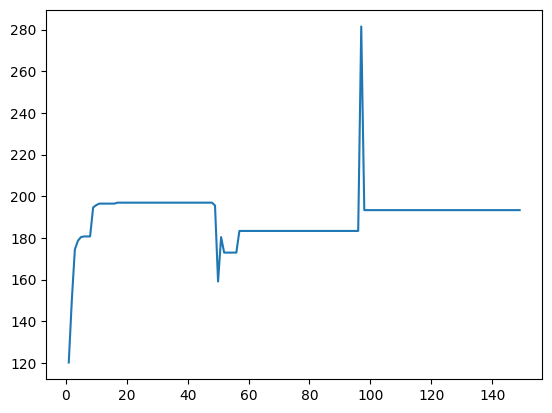

In [868]:
plt.plot([i for i in range(1,150)],mae_list)

## 2. Low Rank Adaptation

In [877]:
def longest_missing_segment(series):
    """
    Trouve la plus grande portion consécutive de données manquantes (NaN) dans une série temporelle.

    Paramètres :
    - series : array-like (pandas Series ou numpy array), la série temporelle.

    Retourne :
    - max_gap : longueur de la plus grande séquence continue de NaN.
    """
    is_nan = np.isnan(series)  # Masque booléen des NaN
    max_gap = 0  # Longueur max de la séquence de NaN
    current_gap = 0  # Compteur temporaire

    for missing in is_nan:
        if missing:
            current_gap += 1  # Incrémentation si NaN
        else:
            max_gap = max(max_gap, current_gap)  # Mise à jour du max
            current_gap = 0  # Réinitialisation si valeur valide

    # Vérification à la fin (si la série se termine par des NaN)
    max_gap = max(max_gap, current_gap)

    return max_gap

In [1046]:
def create_trajectory_matrix(series, window_size):
    """
    Transforme une série temporelle en matrice de trajectoire (Hankel matrix).
    """
    n = len(series)
    num_rows = n - window_size + 1
    trajectory_matrix = np.array([series[i:i+window_size] for i in range(num_rows)])
    return trajectory_matrix

def reconstruct_missing_values(X, W, rank=5, max_iter=1000, tol=1e-4):
    """
    Applique la factorisation de rang réduit (Low-Rank Approximation) pour compléter les valeurs manquantes.
    
    X : Matrice de trajectoire avec des valeurs manquantes.
    W : Matrice masque (1 = valeur connue, 0 = valeur manquante).
    rank : Rang attendu pour l'approximation.
    max_iter : Nombre maximal d'itérations.
    tol : Tolérance pour l'arrêt.
    """
    # Initialisation avec les valeurs connues
    X_hat = np.copy(X)
    #X_hat[W == 0] = np.nanmean(X)  # Remplacement initial des NaN par la moyenne

    for _ in range(max_iter):
        # Étape SVD
        U, S, Vt = svd(X * W + X_hat * (1 - W), full_matrices=False)
        
        # Approximation de rang réduit
        S[rank:] = 0  # On garde seulement les `rank` premiers éléments de S
        X_new = U @ np.diag(S) @ Vt
        
        # Vérification de la convergence
        error = np.linalg.norm((X_new - X_hat) * (1 - W)) / np.linalg.norm(X_new)
        X_hat = X_new
        
        if error < tol:
            break

    return X_hat

def recontruct_from_trajectory_matrix(trajectory_matrix):
    
    L, W = trajectory_matrix.shape  # L = nombre de lignes (fenêtres), W = taille de la fenêtre
    reconstructed_series = np.zeros(L + W - 1)  # Série temporelle finale
    counts = np.zeros(L + W - 1)  # Compteur pour la moyenne sur les recouvrements
    
    for i in range(L):
        reconstructed_series[i:i+W] += trajectory_matrix[i]  # Ajout des valeurs de la fenêtre
        counts[i:i+W] += 1  # Comptage du nombre de fois où un point est inclus
        
    reconstructed_series /= counts
    return reconstructed_series

def complete_time_series(series, window_size):
    """
    Complète une série temporelle en appliquant le Low-Rank Adaptation sur la matrice de trajectoire.
    
    series : Série temporelle avec des valeurs manquantes.
    window_size : Taille de la fenêtre pour la matrice de trajectoire.
    rank : Rang pour la factorisation.
    """
    # Construction de la matrice de trajectoire
    rank = int(window_size*0.9)
    trajectory_matrix = create_trajectory_matrix(series, window_size)
    
    # Création de la matrice masque W
    W = (~np.isnan(trajectory_matrix)).astype(float)
    
    # Remplacement temporaire des NaN pour éviter les erreurs de calcul
    X = np.nan_to_num(trajectory_matrix, nan=1)

    # Reconstruction de la matrice complétée
    X_completed = reconstruct_missing_values(X, W, rank=rank)

    # Reconstruction de la série temporelle
    reconstructed_series = recontruct_from_trajectory_matrix(X_completed)

    return reconstructed_series

completed_serie = complete_time_series(TS_missing.loc[:,"holed_8"], int(0.9*longest_missing_segment(TS_missing.loc[:,"holed_1"])))

In [1047]:
completed_serie

array([603.27005488, 527.10441204, 544.40006015, ..., 541.12491311,
       538.87609256, 622.21429573])

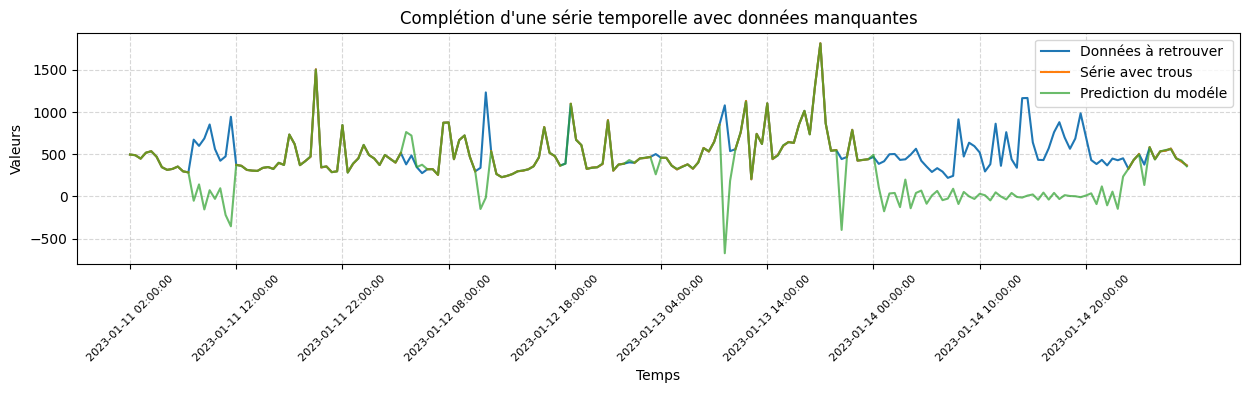

In [1048]:
fig, ax = fig_ax()
ax.plot(data_train["holed_8"][100:300], alpha=1, label='Données à retrouver')
ax.plot(TS_missing["holed_8"][100:300], label='Série avec trous')
ax.plot(completed_serie[100:300], alpha=0.7, label='Prediction du modéle')
ax.set_xticks(range(0, 200, 20))  # Affichage tous les 10 points
ax.set_xticklabels(data_train.index[100:300:20], rotation=45, fontsize=8)  # Rotation pour lisibilité
ax.set_title("Complétion d'une série temporelle avec données manquantes")
ax.set_xlabel("Temps")
ax.set_ylabel("Valeurs")

# Ajout d'une grille légère
ax.grid(True, linestyle='--', alpha=0.5)

# Ajout d'une légende
ax.legend()
plt.savefig('plots_raport/Lora.png', dpi=500)
plt.show()

In [880]:
serie_list = []
for serie in tqdm(test_series):
    serie_list.append(complete_time_series(TS_missing.loc[:,serie], int(1.5*longest_missing_segment(TS_missing.loc[:,serie]))))

  0%|          | 0/200 [00:00<?, ?it/s]

100%|██████████| 200/200 [09:07<00:00,  2.74s/it]


In [882]:
serie_list = np.array(serie_list)
serie_list

array([[ 1.03035407e+03,  9.95397857e+02,  9.67886946e+02, ...,
         1.40769431e+03,  1.66145224e+03,  1.59108629e+03],
       [ 2.12550605e-16,  1.17385267e-16,  7.47349276e-17, ...,
        -5.68968318e-05, -9.61998914e-05, -1.27912992e-04],
       [ 1.27052329e+02,  1.33028308e+02,  1.29020320e+02, ...,
         6.55685676e+02,  6.04891960e+02,  5.32489359e+02],
       ...,
       [ 1.56100557e+02,  1.04174622e+02,  1.44252463e+02, ...,
         1.81547734e+00, -1.84355379e+02,  6.14237107e+01],
       [ 2.04553368e+02,  2.19968144e+02,  2.43385061e+02, ...,
         2.75818628e+02,  2.36238529e+02,  2.29067676e+02],
       [ 3.39899660e+02,  3.15998585e+02,  2.81482098e+02, ...,
         5.12132566e+01,  5.67305362e+01,  5.45735021e+01]])

In [883]:
missing_idx = np.isnan(TS_missing[test_series].values)
mae = mean_absolute_error(data_train[test_series].values[missing_idx], serie_list.T[missing_idx])
print(mae)

179.04447954684048


In [959]:
def filter_true_sequences(arr: np.ndarray, min_length: int) -> np.ndarray:
    """
    Conserve uniquement les séquences de True d'une longueur donnée dans un tableau numpy 2D,
    en remplaçant les autres valeurs par False. La vérification se fait uniquement sur les colonnes.
    
    :param arr: np.ndarray booléen 2D contenant des True et False
    :param min_length: Longueur minimale des séquences de True à conserver
    :return: Nouveau tableau avec uniquement les séquences valides conservées
    """
    result = np.zeros_like(arr, dtype=bool)
    
    # Parcours des colonnes
    for j in range(arr.shape[1]):
        true_indices = np.where(arr[:, j])[0]  # Indices des True
        if len(true_indices) > 0:
            splits = np.split(true_indices, np.where(np.diff(true_indices) != 1)[0] + 1)  # Séquences continues
            for seq in splits:
                if len(seq) == min_length:
                    result[seq, j] = True
    
    return result

mae_list = []
num_list = []
for i in range(1,300):
    try:
        filtered_tab = filter_true_sequences(missing_idx, i)
        mae = mean_absolute_error(data_train[test_series].values[filtered_tab], serie_list.T[filtered_tab])
        mae_list.append(mae)
        num_list.append(i)
    except:
        pass

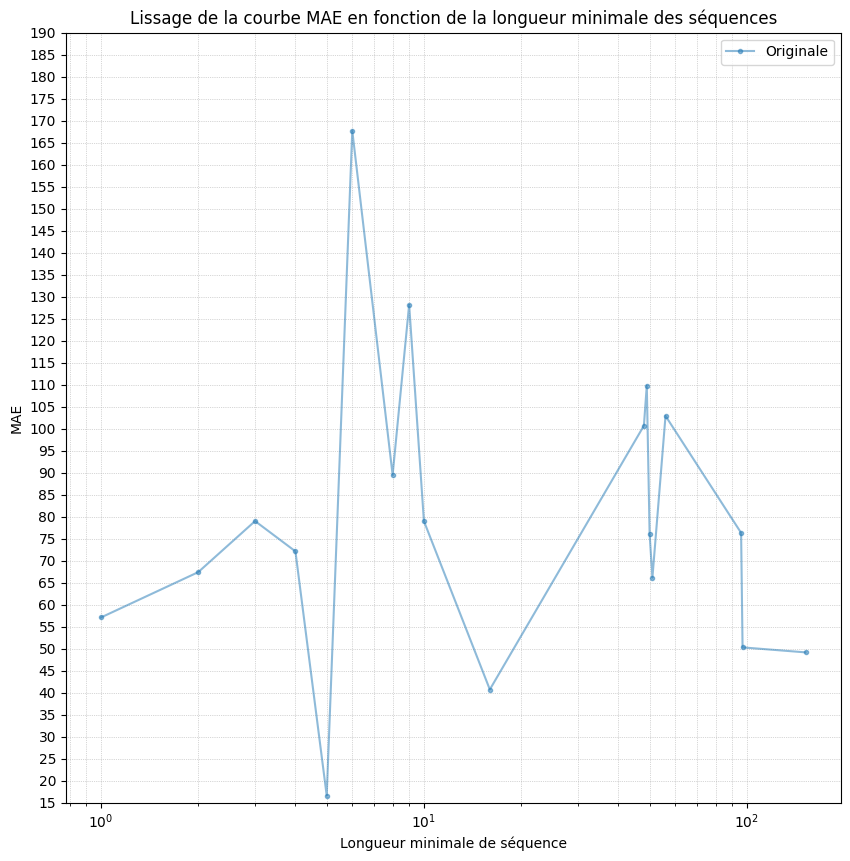

In [1282]:
# Appliquer un filtre gaussien pour lisser la courbe
smoothed_mae = gaussian_filter1d(mae_list, sigma=2)

# Tracer la courbe originale et lissée
plt.figure(figsize=(10, 10))
plt.plot(num_list, mae_list, label="Originale", alpha=0.5, marker=".")
# plt.plot(num_list, smoothed_mae, label="Lissée (Gaussien)", linewidth=2)

# Ajout des labels et du titre
plt.xlabel("Longueur minimale de séquence")
plt.ylabel("MAE")
plt.title("Lissage de la courbe MAE en fonction de la longueur minimale des séquences")
plt.legend()

# Échelle logarithmique pour l'axe X
plt.xscale('log')
plt.ylim((15,190))

# Ajouter plus de graduations sur l'axe Y
ax = plt.gca()  # Récupérer l'axe courant
ax.yaxis.set_major_locator(ticker.MultipleLocator(5))  # Graduation principale tous les 2
# ax.yaxis.set_minor_locator(ticker.MultipleLocator(0))  # Graduation mineure tous les 1
ax.grid(which='both', linestyle=':', linewidth=0.5)  # Ajouter une grille pour plus de clarté
plt.savefig('plots_raport/LORA_Analysis.png', dpi=500)

plt.show()

## 3. XGBoost + PCA

In [171]:
complete_TS

""
Horodate
2023-01-09 00:00:00
2023-01-09 00:30:00
2023-01-09 01:00:00
2023-01-09 01:30:00
2023-01-09 02:00:00
...
2023-01-30 22:00:00
2023-01-30 22:30:00
2023-01-30 23:00:00


In [1262]:
pca = PCA(n_components=60)
test_pca = pca.fit_transform(df_test_complete)#pca.fit_transform(complete_TS)

In [1263]:
# Création du DataFrame pour le modèle
data_xg = []

for col_ind, col in enumerate(TS_missing.columns):
    for row_ind, t in enumerate(TS_missing.index):  # Parcours des timestamps
        if pd.isna(TS_missing.loc[t, col]):  # On ne prend que les valeurs manquantes
            features_t = test_pca[row_ind]  # Les 100 features`
            features_t_plus = test_pca[max(row_ind-1,0)]
            features_t_moins = test_pca[min(row_ind+1,len(test_pca)-1)]
            previous_indice = TS_missing[col][:row_ind].last_valid_index() 
            next_indice = TS_missing[col][row_ind:].first_valid_index()
            previous_value = TS_missing.loc[previous_indice if previous_indice is not None else next_indice, col]
            next_value = TS_missing.loc[next_indice if next_indice is not None else previous_indice, col]
            target = data_train.loc[t, col]  # Valeur réelle reconstruite

            data_xg.append([col, t, previous_value, next_value, *features_t, *features_t_plus, *features_t_moins, target])

# Conversion en DataFrame
columns = ["series_id", "timestamp", "previous_value", "next_value"] + [f"feature_{i}" for i in range(test_pca.shape[1])] + [f"feature_plus_{i}" for i in range(test_pca.shape[1])] + [f"feature_moin_{i}" for i in range(test_pca.shape[1])] + ["target"]
df_model_xg = pd.DataFrame(data_xg, columns=columns)

In [1264]:
df_model_xg.isnull().sum().max()

np.int64(0)

In [1268]:
# Filtrer les données d'entraînement et de test
df_train_ = df_model_xg[df_model_xg["series_id"].isin(train_series)]
df_test_ = df_model_xg[df_model_xg["series_id"].isin(test_series)]

# Séparation des features et de la cible
X_train = df_train_.drop(columns=["series_id", "timestamp", "target"])
y_train = df_train_["target"]

X_test = df_test_.drop(columns=["series_id", "timestamp", "target"])
y_test = df_test_["target"]

In [1278]:
# Définition du modèle
params = {
    "objective": "reg:squarederror",
    "eval_metric": "mae",
    "learning_rate": 0.05,
    "max_depth": 5,
    "n_estimators": 100
}

model = xgb.XGBRegressor(**params)

# Entraînement
model.fit(X_train, y_train, eval_set=[(X_test, y_test), (X_train, y_train)], verbose=True)

# Prédiction des valeurs manquantes
y_pred = model.predict(X_test)

[0]	validation_0-mae:315.32849	validation_1-mae:311.72193
[1]	validation_0-mae:302.29822	validation_1-mae:299.20182
[2]	validation_0-mae:289.84466	validation_1-mae:287.38597
[3]	validation_0-mae:278.06931	validation_1-mae:276.25046
[4]	validation_0-mae:266.88924	validation_1-mae:265.74123
[5]	validation_0-mae:256.47094	validation_1-mae:255.86400
[6]	validation_0-mae:246.62454	validation_1-mae:246.57756
[7]	validation_0-mae:237.37234	validation_1-mae:237.79268
[8]	validation_0-mae:228.71053	validation_1-mae:229.54546
[9]	validation_0-mae:220.65985	validation_1-mae:221.74774
[10]	validation_0-mae:213.17895	validation_1-mae:214.46071
[11]	validation_0-mae:205.99816	validation_1-mae:207.60407
[12]	validation_0-mae:199.43773	validation_1-mae:201.12753
[13]	validation_0-mae:193.09754	validation_1-mae:195.04745
[14]	validation_0-mae:187.25751	validation_1-mae:189.32236
[15]	validation_0-mae:181.71571	validation_1-mae:183.94958
[16]	validation_0-mae:176.63695	validation_1-mae:178.89312
[17]	va

In [ ]:
mae_list = []
num_list = []
seq_count_list = []
for i in range(1,300):
    try:
        filtered_tab = filter_true_sequences(missing_idx, i)
        mae = mean_absolute_error(data_train[serie_list].values[filtered_tab], serie_list_VARMAX.T[filtered_tab])
        
        # Compter le nombre de séquences valides conservées
        # seq_count = sum(
        #     1 for j in range(filtered_tab.shape[1]) 
        #     if len(np.where(filtered_tab[:, j])[0]) == i
        # )
        
        mae_list.append(mae)
        num_list.append(i)
        # seq_count_list.append(seq_count)
    except Exception as e:
        pass

In [234]:
# Prédiction avec le modèle entraîné
data_xg_test = []

for col_ind, col in enumerate(df_test_missing.columns):
    for row_ind, t in enumerate(df_test_missing.index):  # Parcours des timestamps
        if pd.isna(df_test_missing.loc[t, col]):  # On ne prend que les valeurs manquantes
            features_t = test_features[row_ind]  # Les 100 features
            col_ = df_test_missing[col][:row_ind]
            previous_indice = df_test_missing[col][:row_ind].last_valid_index() 
            next_indice = df_test_missing[col][row_ind:].first_valid_index()
            previous_value = df_test_missing.loc[previous_indice if previous_indice is not None else next_indice, col] 
            next_value = df_test_missing.loc[next_indice if next_indice is not None else previous_indice, col]
            data_xg_test.append([col, t, previous_value, next_value, *features_t])

# Conversion en DataFrame
columns = ["series_id", "timestamp", "previous_value", "next_value"] + [f"feature_{i}" for i in range(test_features.shape[1])]
df_model_xg_test = pd.DataFrame(data_xg_test, columns=columns)

In [1277]:
y_pred_test = model.predict(df_model_xg_test.drop(columns=["series_id", "timestamp"]))

NameError: name 'df_model_xg_test' is not defined

In [1280]:
# Prédiction avec le modèle entraîné
data_xg_pred = TS_missing.copy()

count = 0
for col_ind, col in enumerate(df_test_missing.columns):
    for row_ind, t in enumerate(df_test_missing.index):  # Parcours des timestamps
        if pd.isna(df_test_missing.loc[t, col]):  # On ne prend que les valeurs manquantes
            assert count < len(y_pred)
            data_xg_pred.loc[t, col] = y_pred[count]
            count += 1

AssertionError: 

In [1276]:
# Prédiction avec le modèle entraîné
data_xg_test_pred = df_test_missing.copy()

count = 0
for col_ind, col in enumerate(df_test_missing.columns):
    for row_ind, t in enumerate(df_test_missing.index):  # Parcours des timestamps
        if pd.isna(df_test_missing.loc[t, col]):  # On ne prend que les valeurs manquantes
            assert count < len(y_pred_test)
            data_xg_test_pred.loc[t, col] = y_pred_test[count]
            count += 1

NameError: name 'y_pred_test' is not defined

In [238]:
data_xg_test_pred.to_csv("results/Test_XGboost_PCA_pca_300.csv", index=True)

## 4. AR Based Interpolation

In [1283]:
def ar_interpolation(x, p):
    x_interpolated = x.copy()
    missing_idx = np.where(np.isnan(x_interpolated))[0]
    known_idx = np.where(~np.isnan(x_interpolated))[0]   
    
    x_interpolated.iloc[missing_idx] = 0
    max_iter = 10
    for _ in range(max_iter):
        _, ar_coeffs, _, _, _ = levinson_durbin(x_interpolated, nlags=p, isacov=False)
        ar_coeffs = np.concatenate([[1], ar_coeffs])
        print(ar_coeffs)
        B = np.zeros((len(missing_idx), len(missing_idx)))
        for i, t in enumerate(missing_idx):
            for j, t_prime in enumerate(missing_idx):
                if abs(t - t_prime) <= p:
                    B[i, j] = np.dot(ar_coeffs[:p-abs(t-t_prime)+1], ar_coeffs[abs(t-t_prime):p+1])
                    B[j, i] = B[i, j]  # Assurer la symétrie
        d = np.zeros(len(missing_idx))
        for i, t in enumerate(missing_idx):
            for k in range(-p,p+1):
                d[i] += B[abs(k), abs(k)]*x.iloc[t-k] if t-k in known_idx else 0
        x_missing = np.linalg.inv(B) @ -d
        x_interpolated.iloc[missing_idx] = x_missing
    return x_interpolated

def select_ar_order(time_series, max_lag=20, method='bic', plot_pacf_graph=True):
    """
    Sélectionne l'ordre optimal p d'un modèle AR(p) pour une série temporelle donnée.

    :param time_series: Série temporelle (Pandas Series)
    :param max_lag: Nombre maximal de lags à tester
    :param method: Critère de sélection ('aic' ou 'bic')
    :param plot_pacf_graph: Afficher ou non le graphe PACF
    :return: Ordre optimal p
    """
    # Suppression des valeurs manquantes
    time_series = time_series.dropna()

    # 1️⃣ Vérification de la stationnarité (ADF Test)
    adf_test = adfuller(time_series)
    if adf_test[1] > 0.05:
        print("⚠️ La série n'est pas stationnaire ! Essayez une différenciation.")

    # 2️⃣ Calcul de la PACF pour obtenir une première estimation de p
    pacf_values = pacf(time_series, nlags=max_lag, method='ywm')
    estimated_p = np.argmax(np.abs(pacf_values[1:]) < 1.96 / np.sqrt(len(time_series))) + 1  # Dernier lag significatif

    if plot_pacf_graph:
        plot_pacf(time_series, lags=max_lag, method='ywm')
        plt.show()

    # 3️⃣ Sélection du meilleur p avec AIC/BIC
    best_p = 1
    best_criteria = np.inf

    for p in range(1, max_lag + 1):
        try:
            model = AutoReg(time_series, lags=p).fit()
            criteria_value = model.aic if method == 'aic' else model.bic

            if criteria_value < best_criteria:
                best_p = p
                best_criteria = criteria_value

        except:
            continue
    if plot_pacf_graph:
        print(f"📌 Estimation PACF: p = {estimated_p}")
        print(f"✅ Meilleur p selon {method.upper()}: p = {best_p}")

    return best_p

[ 1.          0.43441927 -0.22752935]
[ 1.          0.04408735 -0.1974955 ]
[ 1.          0.2676978  -0.27338853]
[ 1.          0.15126824 -0.2201746 ]
[ 1.          0.21498619 -0.26158055]
[ 1.          0.18183399 -0.23423804]
[ 1.          0.19952487 -0.25219636]
[ 1.          0.19032794 -0.24100803]
[ 1.          0.19513796 -0.24788331]
[ 1.          0.19266017 -0.2437618 ]


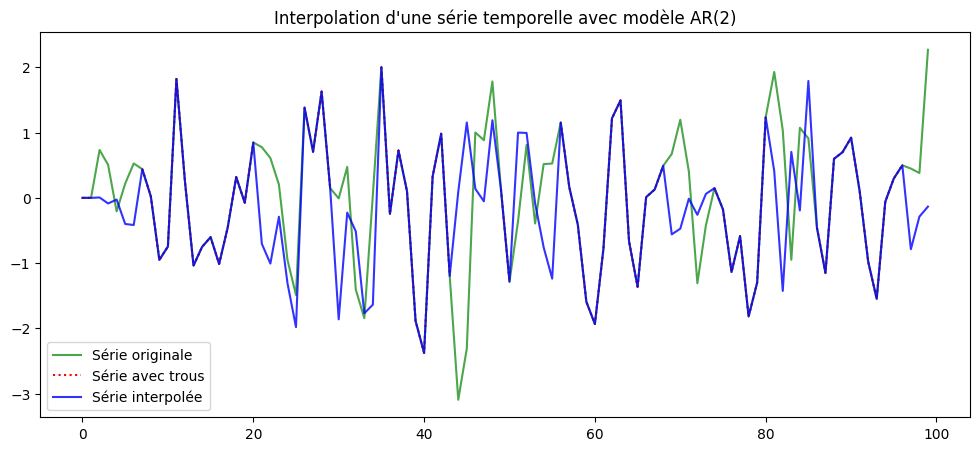

In [1284]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# 🔹 1️⃣ Générer une série AR(2)
N = 1000
phi1, phi2 = 0.5, -0.3
y = np.zeros(N)
epsilon = np.random.normal(0, 1, N)

for t in range(2, N):
    y[t] = phi1 * y[t-1] + phi2 * y[t-2] + epsilon[t]

# 🔹 2️⃣ Introduire des trous (remplacement par NaN)
def introduce_missing_values(series, missing_rate=0.1, burst_length=5):
    """
    Introduit des valeurs manquantes en remplaçant des segments par NaN.
    """
    series_with_missing = series.copy()
    n_missing = int(len(series) * missing_rate)  # Nombre total de valeurs manquantes
    missing_indices = np.random.choice(len(series), n_missing, replace=False)
    
    for idx in missing_indices:
        series_with_missing[idx:idx+burst_length] = np.nan  # Créer des trous en rafales

    return series_with_missing

# Appliquer des trous sur la série
y_missing = introduce_missing_values(y, missing_rate=0.1, burst_length=5)

# 🔹 3️⃣ Appliquer l'interpolation AR(p=2)
ts_interpolated = ar_interpolation(pd.Series(y_missing), p=2)

# 🔹 4️⃣ Visualisation
plt.figure(figsize=(12, 5))
plt.plot(y[:100], label="Série originale", color="green", alpha=0.7)
plt.plot(y_missing[:100], label="Série avec trous", color="red", linestyle="dotted")
plt.plot(ts_interpolated[:100], label="Série interpolée", color="blue", alpha=0.8)
plt.legend()
plt.title("Interpolation d'une série temporelle avec modèle AR(2)")
plt.show()

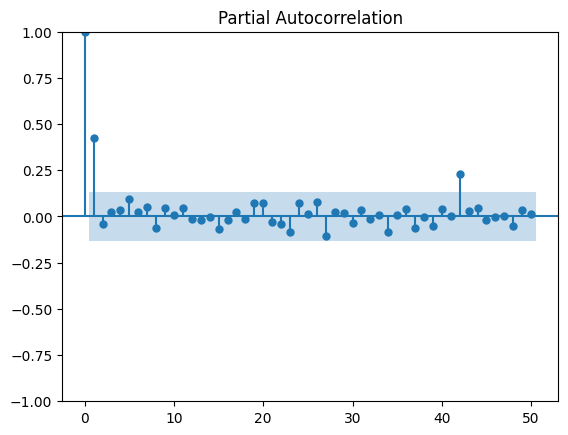

📌 Estimation PACF: p = 2
✅ Meilleur p selon BIC: p = 1
[ 1.          0.41225182 -0.04663672 -0.00440133  0.08505358  0.0220038
  0.00879046 -0.01461398 -0.06612223  0.07255217  0.01205213 -0.04169173
  0.02515856 -0.00557513  0.01117381 -0.01139545  0.07867876 -0.06765268
  0.03250659 -0.00820056  0.0399933   0.03063159  0.12911063 -0.03541855
 -0.12958483  0.03626267]
[ 1.          0.30056102  0.13895905  0.09824369 -0.00308197  0.1629767
 -0.03641372 -0.02547278 -0.03366604 -0.02884484 -0.0742558   0.06159118
  0.06913897 -0.03388852 -0.00917277  0.03796854 -0.00194284  0.02907411
 -0.05339791 -0.04905865  0.07057824 -0.024284   -0.03932298 -0.02239303
 -0.04177981  0.07370157]
[ 1.00000000e+00  2.93299942e-01  6.75870405e-02  1.04122793e-01
  8.40521887e-05  1.22203106e-01  5.62524696e-03 -2.04335574e-03
 -3.39619409e-02 -2.13609052e-02 -4.79765164e-02  1.20927241e-02
  5.90394433e-02 -2.37783138e-02  4.97678070e-03  2.56307030e-02
  3.73827100e-02  1.48087071e-02 -4.49164016e-02 -5

In [303]:
serie = "holed_8"
y = TS_missing.loc[:,serie].copy()
y = y.iloc[:300]
mean = y.mean()
std = y.std()
y = (y - mean)/std
p = select_ar_order(y,50,'bic')
ts_interpolated = ar_interpolation(y, p=25)

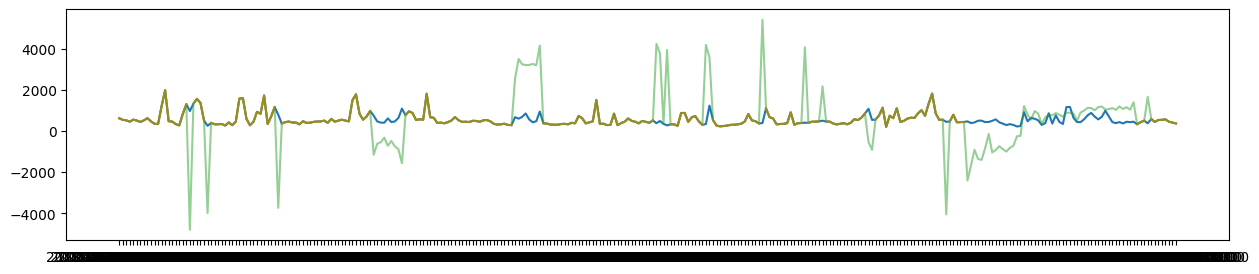

In [304]:
fig, ax = fig_ax()
ax.plot(data_train[serie][0:300], alpha=1)
ax.plot(TS_missing[serie][0:300])
ax.plot(ts_interpolated[0:300]*std+mean, alpha=0.5)
plt.show()

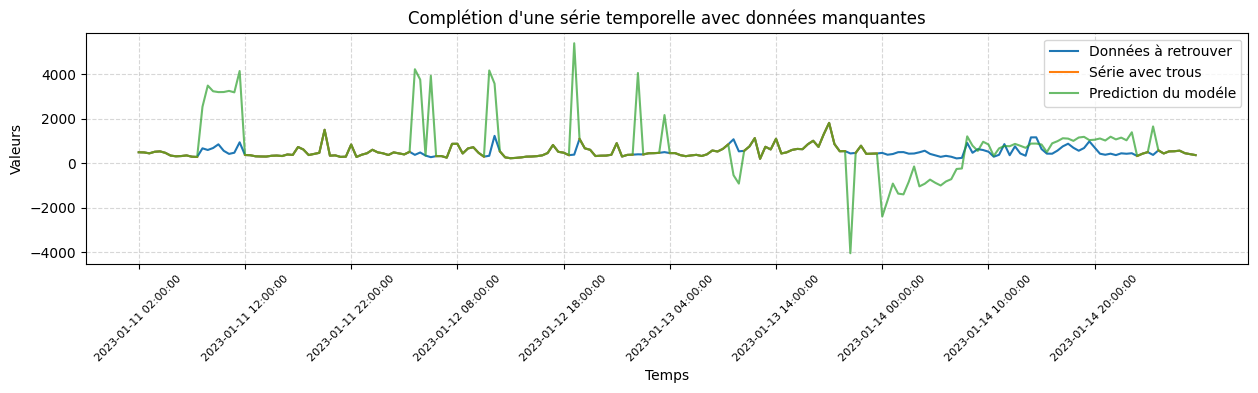

In [307]:
fig, ax = fig_ax()
ax.plot(data_train["holed_8"][100:300], alpha=1, label='Données à retrouver')
ax.plot(TS_missing["holed_8"][100:300], label='Série avec trous')
ax.plot(ts_interpolated[100:300]*std+mean, alpha=0.7, label='Prediction du modéle')
ax.set_xticks(range(0, 200, 20))  # Affichage tous les 10 points
ax.set_xticklabels(data_train.index[100:300:20], rotation=45, fontsize=8)  # Rotation pour lisibilité
ax.set_title("Complétion d'une série temporelle avec données manquantes")
ax.set_xlabel("Temps")
ax.set_ylabel("Valeurs")

# Ajout d'une grille légère
ax.grid(True, linestyle='--', alpha=0.5)

# Ajout d'une légende
ax.legend()
plt.savefig('plots_raport/AR.png', dpi=500)
plt.show()

In [284]:
serie_list_AR = []

for serie in tqdm(test_series):
    y = TS_missing.loc[:, serie].copy()
    mean = y.mean()
    y = y - mean  # Centrer la série

    try:
        # Sélection de l'ordre optimal du modèle AR
        p = select_ar_order(y, 50, 'bic', plot_pacf_graph=False)

        # Interpolation AR(p)
        ts_interpolated = ar_interpolation(y, p=p)

        # Restaurer la moyenne
        ts_interpolated += mean  

    except Exception as e:
        print(f"⚠️ Erreur avec {serie}, interpolation linéaire appliquée ({e})")

        # Fallback : Interpolation linéaire
        ts_interpolated = y.interpolate(method='linear', limit_direction='both')

    # Ajouter la série interpolée à la liste
    serie_list_AR.append(ts_interpolated)

  2%|▏         | 3/200 [00:00<00:09, 20.10it/s]

⚠️ Erreur avec holed_795, interpolation linéaire appliquée (Invalid input, x is constant)


  3%|▎         | 6/200 [00:00<00:14, 13.47it/s]

⚠️ La série n'est pas stationnaire ! Essayez une différenciation.


 14%|█▍        | 28/200 [00:02<00:12, 14.09it/s]

⚠️ La série n'est pas stationnaire ! Essayez une différenciation.


 17%|█▋        | 34/200 [00:02<00:11, 14.34it/s]

⚠️ Erreur avec holed_320, interpolation linéaire appliquée (Invalid input, x is constant)


 24%|██▍       | 49/200 [00:03<00:08, 16.99it/s]

⚠️ Erreur avec holed_578, interpolation linéaire appliquée (Invalid input, x is constant)


 26%|██▋       | 53/200 [00:03<00:08, 16.99it/s]

⚠️ La série n'est pas stationnaire ! Essayez une différenciation.


 38%|███▊      | 77/200 [00:05<00:08, 13.81it/s]

⚠️ La série n'est pas stationnaire ! Essayez une différenciation.


 44%|████▎     | 87/200 [00:06<00:08, 12.92it/s]

⚠️ La série n'est pas stationnaire ! Essayez une différenciation.


 48%|████▊     | 97/200 [00:07<00:07, 14.40it/s]

⚠️ La série n'est pas stationnaire ! Essayez une différenciation.


 54%|█████▎    | 107/200 [00:07<00:06, 15.27it/s]

⚠️ La série n'est pas stationnaire ! Essayez une différenciation.


 74%|███████▎  | 147/200 [00:10<00:04, 12.82it/s]

⚠️ La série n'est pas stationnaire ! Essayez une différenciation.


 88%|████████▊ | 176/200 [00:12<00:01, 14.83it/s]

⚠️ La série n'est pas stationnaire ! Essayez une différenciation.


 94%|█████████▍| 188/200 [00:13<00:00, 12.77it/s]

⚠️ La série n'est pas stationnaire ! Essayez une différenciation.


 96%|█████████▌| 192/200 [00:14<00:00, 12.71it/s]

⚠️ Erreur avec holed_838, interpolation linéaire appliquée (Invalid input, x is constant)


100%|██████████| 200/200 [00:14<00:00, 13.74it/s]


In [285]:
np.isnan(serie_list_AR).sum()

np.int64(0)

In [286]:
serie_list_AR = np.array(serie_list_AR)
missing_idx = np.isnan(TS_missing[test_series].values)
mae = mean_absolute_error(data_train[test_series].values[missing_idx], serie_list_AR.T[missing_idx])
print(mae)

220.3655077134005


## 5. Vector Auto Regressive Interpolation

In [329]:
pca = PCA(n_components=60)
feature_pca = pca.fit_transform(df_test_complete) #pca.fit_transform(complete_TS)
feature_pca = pd.DataFrame(feature_pca, index=complete_TS.index, columns=[f"feature_{i}" for i in range(feature_pca.shape[1])])
temp = feature_pca.index
feature_pca.index = pd.to_datetime(feature_pca.index)
feature_pca["day_of_week"] = feature_pca.index.dayofweek  # Jour de la semaine (0 = Lundi, 6 = Dimanche)
feature_pca["hour"] = feature_pca.index.hour  # Heure si fréquence intraday
feature_pca["month"] = feature_pca.index.month  # Mois
feature_pca.index = temp
feature_pca.head()

,feature_0,feature_1,feature_2,feature_3,feature_4,feature_5,feature_6,feature_7,feature_8,feature_9,...,feature_53,feature_54,feature_55,feature_56,feature_57,feature_58,feature_59,day_of_week,hour,month
Horodate,,,,,,,,,,,,,,,,,,,,,
2023-01-09 00:00:00,-25856.843481,19083.073312,-11412.651173,-4753.162365,-4151.186824,-7914.224402,6504.942959,-2683.679210,2904.776099,11100.812878,...,740.763631,978.222922,3498.102960,-567.085625,1157.001631,520.981884,98.813346,0,0,1
2023-01-09 00:30:00,-27215.683251,19324.017477,-8413.899442,-3486.260044,-4401.667401,-5994.585593,8764.790714,-4138.399082,3612.403844,10118.087154,...,293.487544,1981.382636,2882.946432,1029.038244,1138.205715,-1150.546274,3456.985754,0,0,1
2023-01-09 01:00:00,-28829.713192,18679.817680,-3772.600132,559.605767,-4800.692077,-3131.299179,10711.854813,-4611.375290,3445.002997,6516.492072,...,-312.427457,3500.052204,162.598799,1065.497512,-567.212819,-2107.929712,4161.493762,0,1,1
2023-01-09 01:30:00,-29753.089982,17644.940864,1279.580673,3985.666959,-4079.146047,-217.299257,11771.634068,-5509.797547,1525.804241,3688.937194,...,-1204.311808,2936.063077,-110.425981,-2294.187782,-524.367001,-1461.940482,3238.598513,0,1,1
2023-01-09 02:00:00,-28382.902443,17045.986468,6716.731995,6834.332991,-2988.195355,3912.338578,11387.613165,-5162.089678,-1144.543077,1684.238715,...,76.548602,2211.815462,1481.679249,-1732.804951,383.368206,-2142.780615,417.936546,0,2,1


In [1250]:
def train_autoencoder(data, encoding_dim=10, epochs=100):
    """
    Entraîne un autoencodeur pour nettoyer les séries PCA.
    """
    input_dim = data.shape[1]
    
    input_layer = Input(shape=(input_dim,))
    encoded = Dense(encoding_dim, activation='relu')(input_layer)
    decoded = Dense(input_dim, activation='linear')(encoded)

    autoencoder = Model(input_layer, decoded)
    autoencoder.compile(optimizer='adam', loss='mse')

    autoencoder.fit(data, data, epochs=epochs, verbose=0)
    
    return autoencoder

# Entraîner sur les séries PCA
autoencoder = train_autoencoder(feature_pca.values)

# Reconstruire les séries débruitées
pca_series_clean = pd.DataFrame(autoencoder.predict(feature_pca.values), index=feature_pca.index)

34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 789us/step


In [332]:
def fill_past_data(combined_data, idx, lag_order):
    """
    Remplit past_data avec les valeurs les plus récentes possibles avant idx.
    Si pas assez, complète avec les valeurs après idx.
    
    Paramètres :
    - combined_data : DataFrame (T, N) avec les séries trouées et PCA.
    - idx : Index où l'on veut prédire.
    - lag_order : Nombre de lags nécessaires.

    Retourne :
    - past_data : Tableau numpy (lag_order, N) prêt pour la prédiction.
    """
    past_values = combined_data.loc[:idx].dropna().iloc[-lag_order:].values

    if past_values.shape[0] < lag_order:  # Si pas assez de valeurs avant
        missing = lag_order - past_values.shape[0]
        future_values = combined_data.loc[idx:].dropna().iloc[:missing].values

        # Concaténer valeurs avant et après si possible
        past_values = np.vstack([past_values, future_values]) if future_values.shape[0] > 0 else past_values

    # Si encore pas assez de données, on répète la dernière valeur connue
    if past_values.shape[0] < lag_order:
        past_values = np.pad(past_values, ((lag_order - past_values.shape[0], 0), (0, 0)), mode='edge')

    return past_values

def detect_missing_sequences(series):
    """
    Détecte les séquences de valeurs manquantes dans une série temporelle.
    Retourne une liste de tuples (start_idx, num_missing) indiquant les plages de NaN.
    """
    missing_sequences = []
    is_missing = series.isna()
    
    i = 0
    while i < len(series):
        if is_missing.iloc[i]:  # Début d'une séquence de NaN
            start_idx = series.index[i]
            num_missing = 1
            
            # Parcourir la suite tant qu'on est sur des NaN
            while i + num_missing < len(series) and is_missing.iloc[i + num_missing]:
                num_missing += 1

            # Sauvegarder la séquence trouvée
            missing_sequences.append((start_idx, num_missing))

            # Avancer à la fin de la séquence actuelle
            i += num_missing
        else:
            i += 1  # Passer aux prochaines valeurs

    return missing_sequences

def var_based_interpolation(holed_series, pca_series, lag_order=5, limit=1):
    """
    Applique l'interpolation VAR en utilisant les séries PCA comme contraintes.

    Paramètres :
    - holed_series : DataFrame (N, T) contenant les séries trouées.
    - pca_series : DataFrame (100, T) contenant les séries PCA complètes.
    - lag_order : Nombre de lags pour le modèle VAR.

    Retourne :
    - holed_series_interpolated : DataFrame avec les valeurs manquantes complétées.
    """

    holed_series_interpolated = holed_series.copy()
    # holed_series.interpolate(method="linear", limit=6, limit_direction="both", inplace=True, axis=0)
    # Concaténer les séries trouées et les séries PCA pour le modèle VAR
    combined_data = pd.concat([holed_series, pca_series], axis=1)  # Transpose pour avoir (T, N)
    
    # Séparer les données connues et manquantes
    train_data = combined_data.dropna()  # Entraînement sur les données complètes
    # if train_data.shape[0] > 20 * lag_order:  # Vérifier si assez de données
    #     try:
    #         aic_lag = VAR(train_data).select_order(maxlags=10*lag_order).aic
    #         if aic_lag is not None:
    #             lag_order = aic_lag
    #         # print(f"🔧 Lag optimal déterminé : {lag_order}")
    #     except Exception as e:
    #         # print(f"Erreur : {e}")
    #         pass
    # Entraîner le modèle VAR
    var_model = VAR(train_data.values)
    # lag_selection = var_model.select_order(maxlags=10)
    # lag_order = min(lag_selection.aic, lag_selection.bic, lag_selection.hqic)
    try:
        var_results = var_model.fit(lag_order)
    except:
        var_results = var_model.fit(lag_order, trend='n')

    # Assurer que tous les index sont bien en DatetimeIndex
    holed_series_interpolated.index = pd.to_datetime(holed_series_interpolated.index)
    combined_data.index = pd.to_datetime(combined_data.index)

    for col in holed_series.columns:
        missing_sequences = detect_missing_sequences(holed_series[col])
        for start_idx, num_missing in missing_sequences:

            # Définir steps dynamiquement pour éviter des oscillations erratiques
            # steps = min(num_missing, 3) if num_missing <= 5 else num_missing  
            steps = num_missing
            # Récupérer les données passées pour la prédiction
            past_data = fill_past_data(combined_data, start_idx, lag_order)

            # Prédire
            prediction = var_results.forecast(past_data, steps=steps)

            # Appliquer la prédiction aux indices correspondants
            missing_range = holed_series[col].loc[start_idx:].index[:num_missing]  # Sélection des indices corrects
            # holed_series_interpolated.loc[missing_range, col] = prediction[:num_missing, 0]
            # Ajuster `num_missing` si la taille du résultat ne correspond pas
            num_predicted = len(prediction)  # Nombre de valeurs prédites par VAR
            if num_predicted < num_missing:
                num_missing = num_predicted  # Ajuste pour éviter un décalage
            if steps <= limit:
                holed_series_interpolated.loc[missing_range, col] = holed_series_interpolated.interpolate(method="linear", limit_direction="both", axis=0).loc[missing_range, col]
                continue

            # Appliquer la mise à jour uniquement si les dimensions correspondent
            if len(missing_range) == num_missing:
                holed_series_interpolated.loc[missing_range, col] = prediction[:num_missing, 0]
            else:
                print(f"⚠️ Problème de taille : {len(missing_range)} timestamps vs {num_missing} prédictions")

    return holed_series_interpolated

In [333]:
serie = "holed_8"
y = TS_missing.loc[:,[serie]]
mean = y.mean()
y = y - mean
# holed_series_interpolated = var_based_interpolation(y.copy(), feature_pca, lag_order=int(1*longest_missing_segment(y)))
holed_series_interpolated = var_based_interpolation(y.copy(), feature_pca, lag_order=2, limit=0)

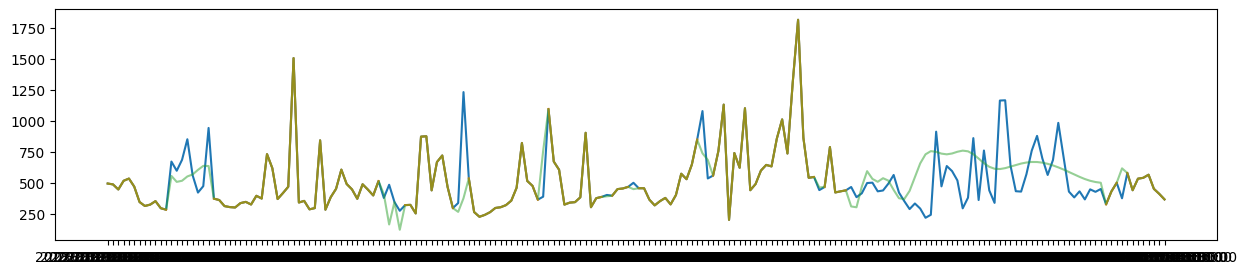

197.921733262112


In [334]:
fig, ax = fig_ax()
ax.plot(data_train[serie][100:300], alpha=1)
ax.plot(TS_missing[serie][100:300])
ax.plot(holed_series_interpolated.iloc[100:300].values+mean.values, alpha=0.5)
plt.show()
missing_idx = np.isnan(TS_missing[serie].values)
mae = mean_absolute_error(data_train[serie].values[missing_idx], holed_series_interpolated[serie].values[missing_idx]+mean.values)
print(mae)

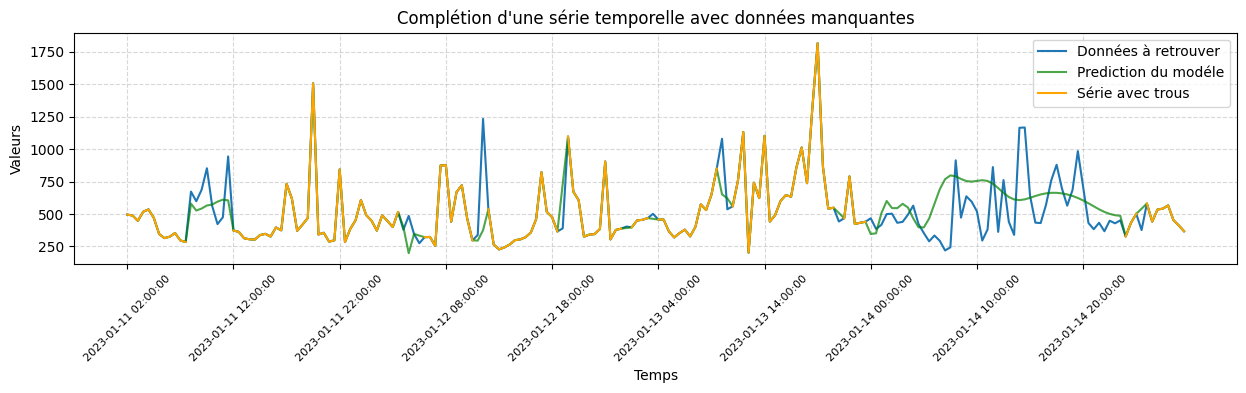

In [36]:
fig, ax = fig_ax()
ax.plot(data_train["holed_8"][100:300], alpha=1, label='Données à retrouver')
ax.plot(holed_series_interpolated.iloc[100:300].values+mean.values, alpha=0.7, label='Prediction du modéle', color='green')
ax.plot(TS_missing["holed_8"][100:300], label='Série avec trous', color="orange")
ax.set_xticks(range(0, 200, 20))  # Affichage tous les 10 points
ax.set_xticklabels(data_train.index[100:300:20], rotation=45, fontsize=8)  # Rotation pour lisibilité
ax.set_title("Complétion d'une série temporelle avec données manquantes")
ax.set_xlabel("Temps")
ax.set_ylabel("Valeurs")

# Ajout d'une grille légère
ax.grid(True, linestyle='--', alpha=0.5)

# Ajout d'une légende
ax.legend()
plt.savefig('plots_raport/VAR_dyn.png', dpi=500)
plt.show()

In [339]:
serie_list_VAR = []

for serie in tqdm(test_series):
    y = TS_missing.loc[:,[serie]]
    mean = y.mean()
    y = y - mean
    # ts_interpolated = var_based_interpolation(y, feature_pca, lag_order=int(1*longest_missing_segment(y))).values
    ts_interpolated = var_based_interpolation(y, feature_pca, lag_order=5, limit=0).values
    ts_interpolated += mean.values  
    serie_list_VAR.append(ts_interpolated)
print(f"Il reste {np.isnan(serie_list_VAR).sum()} NaN")    

100%|██████████| 200/200 [00:28<00:00,  6.99it/s]

Il reste 0 NaN


In [340]:
serie_list_VAR = np.array(serie_list_VAR).squeeze()
missing_idx = np.isnan(TS_missing[test_series].values)
mae = mean_absolute_error(data_train[test_series].values[missing_idx], serie_list_VAR.T[missing_idx])
print(mae)

89.55347136050607


In [1016]:
Limit = [1,2,3,4,5,6,7,8,9,10]
order = [1,2,3,4,5,7,10]

def compute_mae(l, o):
    serie_list_VAR = []
    for serie in test_series:
        y = TS_missing.loc[:,[serie]]
        mean = y.mean()
        y = y - mean
        # ts_interpolated = var_based_interpolation(y, feature_pca, lag_order=int(1*longest_missing_segment(y))).values
        ts_interpolated = var_based_interpolation(y, feature_pca, lag_order=o, limit=l).values
        ts_interpolated += mean.values  
        serie_list_VAR.append(ts_interpolated)
    serie_list_VAR = np.array(serie_list_VAR).squeeze()
    missing_idx = np.isnan(TS_missing[test_series].values)
    mae = mean_absolute_error(data_train[test_series].values[missing_idx], serie_list_VAR.T[missing_idx])
    return mae

mae_ = []
count = 0
nb = len(Limit)*len(order)
for l in Limit:
    for o in order:
        mae_.append({'limit':l, 'ordre':o, "mae":compute_mae(l,o)})
        count += 1
        print(count,"/",nb)

KeyboardInterrupt: 

In [341]:
def filter_true_sequences(arr: np.ndarray, min_length: int) -> np.ndarray:
    """
    Conserve uniquement les séquences de True d'une longueur donnée dans un tableau numpy 2D,
    en remplaçant les autres valeurs par False. La vérification se fait uniquement sur les colonnes.
    
    :param arr: np.ndarray booléen 2D contenant des True et False
    :param min_length: Longueur minimale des séquences de True à conserver
    :return: Nouveau tableau avec uniquement les séquences valides conservées
    """
    result = np.zeros_like(arr, dtype=bool)
    
    # Parcours des colonnes
    for j in range(arr.shape[1]):
        true_indices = np.where(arr[:, j])[0]  # Indices des True
        if len(true_indices) > 0:
            splits = np.split(true_indices, np.where(np.diff(true_indices) != 1)[0] + 1)  # Séquences continues
            for seq in splits:
                if len(seq) == min_length:
                    result[seq, j] = True
    
    return result

mae_list = []
num_list = []
seq_count_list = []
for i in range(1,300):
    try:
        filtered_tab = filter_true_sequences(missing_idx, i)
        mae = mean_absolute_error(data_train[test_series].values[filtered_tab], serie_list_VAR.T[filtered_tab])
        
        # Compter le nombre de séquences valides conservées
        seq_count = sum(
            1 for j in range(filtered_tab.shape[1]) 
            if len(np.where(filtered_tab[:, j])[0]) == i
        )
        
        mae_list.append(mae)
        num_list.append(i)
        seq_count_list.append(seq_count)
    except:
        pass

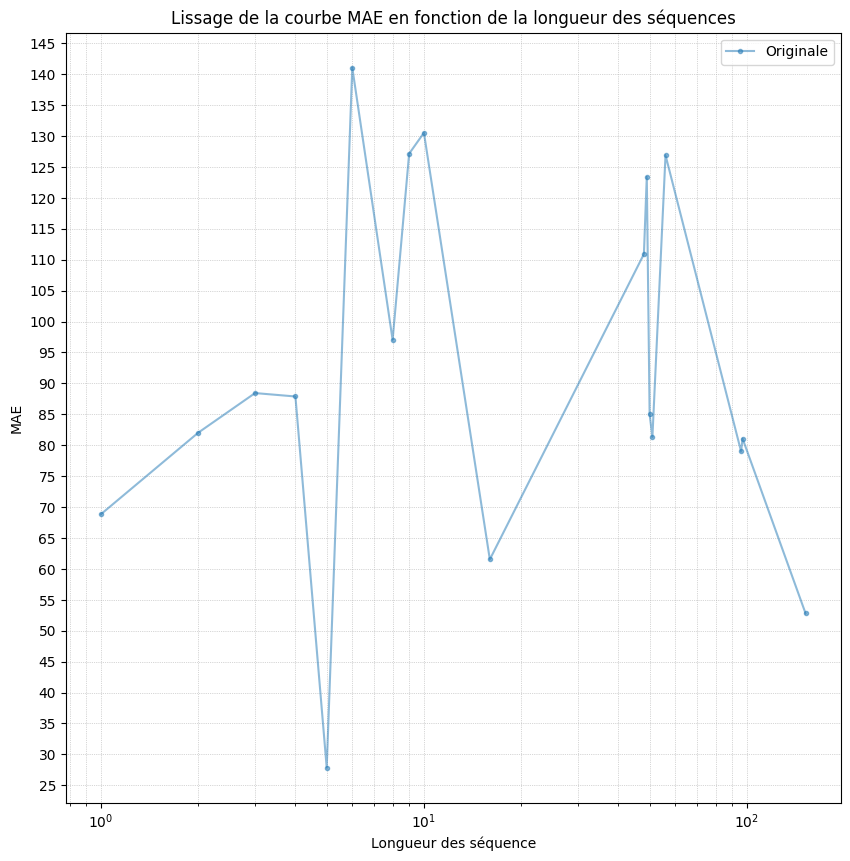

In [342]:
# Appliquer un filtre gaussien pour lisser la courbe
smoothed_mae = gaussian_filter1d(mae_list, sigma=2)

# Tracer la courbe originale et lissée
plt.figure(figsize=(10, 10))
plt.plot(num_list, mae_list, label="Originale", alpha=0.5, marker=".")
# plt.plot(num_list, smoothed_mae, label="Lissée (Gaussien)", linewidth=2)

# Ajout des labels et du titre
plt.xlabel("Longueur des séquence")
plt.ylabel("MAE")
plt.title("Lissage de la courbe MAE en fonction de la longueur des séquences")
plt.legend()

# Échelle logarithmique pour l'axe X
plt.xscale('log')

# Ajouter plus de graduations sur l'axe Y
ax = plt.gca()  # Récupérer l'axe courant
ax.yaxis.set_major_locator(ticker.MultipleLocator(5))  # Graduation principale tous les 2
# ax.yaxis.set_minor_locator(ticker.MultipleLocator(0))  # Graduation mineure tous les 1
ax.grid(which='both', linestyle=':', linewidth=0.5)  # Ajouter une grille pour plus de clarté
plt.savefig('plots_raport/VAR_Analysis_mixed.png', dpi=500)

plt.show()



In [1350]:
holed_series_interpolated = pd.DataFrame()
for serie in tqdm(holed_T_test):
    y = df_test.loc[:,[serie]]
    mean = y.mean()
    y = y - mean
    ts_interpolated = var_based_interpolation(y, feature_pca, lag_order=1, limit=10)
    ts_interpolated += mean
    holed_series_interpolated = pd.concat([holed_series_interpolated, ts_interpolated], axis=1)

  5%|▌         | 50/1000 [00:04<01:17, 12.24it/s]


KeyboardInterrupt: 

In [1013]:
holed_series_interpolated.to_csv('results/VAR_dyn_70_mixed.csv')

In [47]:
def var_interpolation_iterative(holed_series, pca_series, lag_order=5, max_iter=10, tol=1e-4):
    """
    Applique l'interpolation VAR basée sur l'algorithme itératif.

    Paramètres :
    - holed_series : DataFrame (N, T) contenant les séries trouées.
    - pca_series : DataFrame (100, T) contenant les séries PCA complètes.
    - lag_order : Nombre de lags pour le modèle VAR.
    - max_iter : Nombre maximal d'itérations.
    - tol : Tolérance pour convergence (différence entre itérations).

    Retourne :
    - holed_series_interpolated : DataFrame avec les valeurs manquantes complétées.
    """

    holed_series_interpolated = holed_series.copy()

    # Concaténer les séries trouées et les séries PCA comme contraintes pour VAR
    combined_data = pd.concat([holed_series, pca_series], axis=1)  # (T, N)

    # Itération pour raffiner progressivement l'interpolation
    for iteration in tqdm(range(max_iter), desc="VAR Interpolation Iterations"):
        prev_values = holed_series_interpolated.copy()  # Sauvegarde pour vérifier la convergence

        # Entraîner le modèle VAR uniquement sur les données connues
        train_data = combined_data.dropna()
        
        if len(train_data) < lag_order:
            print("❌ Pas assez de données pour entraîner VAR.")
            break

        # # 🔹 Sélection dynamique du lag optimal (optionnel)
        # try:
        #     lag_selection = VAR(train_data).select_order(maxlags=10 * lag_order).aic
        #     if lag_selection is not None:
        #         lag_order = lag_selection
        # except Exception:
        #     pass  # Si erreur, on garde lag_order fixé

        # 🔹 Entraîner le modèle VAR
        var_model = VAR(train_data.values)
        try:
            var_results = var_model.fit(lag_order)
        except:
            var_results = var_model.fit(lag_order, trend='n')

        # 🔹 Mise à jour des valeurs manquantes
        for col in holed_series.columns:
            missing_sequences = detect_missing_sequences(holed_series[col])

            for start_idx, num_missing in missing_sequences:
                steps = num_missing  # Détermine dynamiquement le nombre de steps à prédire
                past_data = fill_past_data(combined_data, start_idx, lag_order)

                # Prédire les valeurs manquantes
                prediction = var_results.forecast(past_data, steps=steps)

                # Sélection des indices correspondants
                missing_range = holed_series[col].loc[start_idx:].index[:num_missing]

                # Ajustement de la taille des prédictions
                num_predicted = len(prediction)
                if num_predicted < num_missing:
                    num_missing = num_predicted  # Ajustement dynamique

                # Mise à jour des valeurs interpolées
                if len(missing_range) == num_missing:
                    holed_series_interpolated.loc[missing_range, col] = prediction[:num_missing, 0]

        # 🔹 Vérification de convergence
        diff = np.linalg.norm(holed_series_interpolated - prev_values)
        if diff < tol:
            print(f"✅ Convergence atteinte après {iteration+1} itérations.")
            break

    return holed_series_interpolated

In [729]:
serie = "holed_11"
y = TS_missing.loc[:,[serie]]
mean = y.mean()
y = y - mean
holed_series_interpolated = var_interpolation_iterative(y, feature_pca, lag_order=int(1*longest_missing_segment(y)))

VAR Interpolation Iterations:  10%|█         | 1/10 [00:00<00:00, 15.62it/s]

✅ Convergence atteinte après 2 itérations.


### Mix Lineaire + Var

In [49]:
def var_based_interpolation_mixed(holed_series, pca_series, lag_order=5, limit=40):
    """
    Applique l'interpolation VAR en utilisant les séries PCA comme contraintes.

    Paramètres :
    - holed_series : DataFrame (N, T) contenant les séries trouées.
    - pca_series : DataFrame (100, T) contenant les séries PCA complètes.
    - lag_order : Nombre de lags pour le modèle VAR.

    Retourne :
    - holed_series_interpolated : DataFrame avec les valeurs manquantes complétées.
    """

    holed_series_interpolated = holed_series.copy()
    print(holed_series_interpolated.isnull().sum().sum())
    holed_series_interpolated.interpolate(method="linear", limit=limit, limit_direction="both", inplace=True, axis=0)
    print(holed_series_interpolated.isnull().sum().sum())
    # Concaténer les séries trouées et les séries PCA pour le modèle VAR
    combined_data = pd.concat([holed_series, pca_series], axis=1)  # Transpose pour avoir (T, N)

    # Séparer les données connues et manquantes
    train_data = combined_data.dropna()  # Entraînement sur les données complètes
    # if train_data.shape[0] > 20 * lag_order:  # Vérifier si assez de données
    #     try:
    #         aic_lag = VAR(train_data).select_order(maxlags=10*lag_order).aic
    #         if aic_lag is not None:
    #             lag_order = aic_lag
    #         # print(f"🔧 Lag optimal déterminé : {lag_order}")
    #     except Exception as e:
    #         # print(f"Erreur : {e}")
    #         pass
    # Entraîner le modèle VAR
    var_model = VAR(train_data.values)
    try:
        var_results = var_model.fit(lag_order)
    except:
        var_results = var_model.fit(lag_order, trend='n')

    # Assurer que tous les index sont bien en DatetimeIndex
    holed_series_interpolated.index = pd.to_datetime(holed_series_interpolated.index)
    combined_data.index = pd.to_datetime(combined_data.index)

    for col in holed_series.columns:
        missing_sequences = detect_missing_sequences(holed_series_interpolated[col])
        for start_idx, num_missing in missing_sequences:
            # Définir steps dynamiquement pour éviter des oscillations erratiques
            # steps = min(num_missing, 3) if num_missing <= 5 else num_missing  
            steps = num_missing
            # Récupérer les données passées pour la prédiction
            past_data = fill_past_data(combined_data, start_idx, lag_order)

            # Prédire
            prediction = var_results.forecast(past_data, steps=steps)

            # Appliquer la prédiction aux indices correspondants
            missing_range = holed_series[col].loc[start_idx:].index[:num_missing]  # Sélection des indices corrects
            # holed_series_interpolated.loc[missing_range, col] = prediction[:num_missing, 0]
            # Ajuster `num_missing` si la taille du résultat ne correspond pas
            num_predicted = len(prediction)  # Nombre de valeurs prédites par VAR
            if num_predicted < num_missing:
                num_missing = num_predicted  # Ajuste pour éviter un décalage

            # Appliquer la mise à jour uniquement si les dimensions correspondent
            if len(missing_range) == num_missing:
                holed_series_interpolated.loc[missing_range, col] = prediction[:num_missing, 0]
            else:
                print(f"⚠️ Problème de taille : {len(missing_range)} timestamps vs {num_missing} prédictions")

    return holed_series_interpolated

In [50]:
serie = "holed_8"
y = TS_missing.loc[:,[serie]]
mean = y.mean()
y = y - mean
holed_series_interpolated = var_based_interpolation_mixed(y, feature_pca, lag_order=int(1*longest_missing_segment(y[serie])))

NameError: name 'longest_missing_segment' is not defined

In [859]:
longest_missing_segment(y[serie])

48

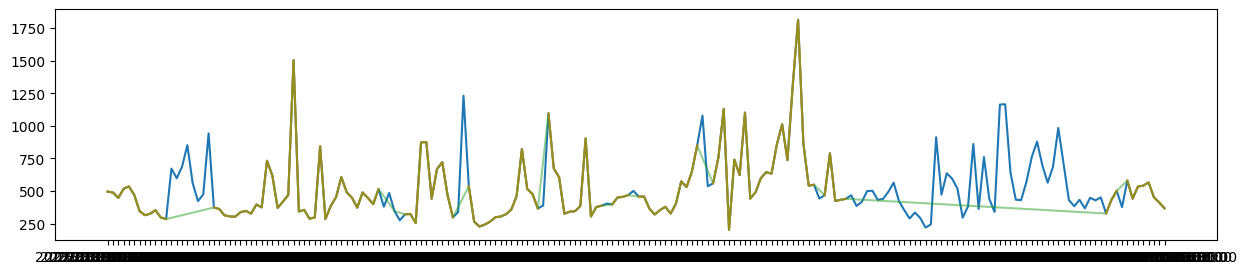

201.02289415766307


In [860]:
fig, ax = fig_ax()
ax.plot(data_train[serie][100:300], alpha=1)
ax.plot(TS_missing[serie][100:300])
ax.plot(holed_series_interpolated.iloc[100:300].values+mean.values, alpha=0.5)
plt.show()
missing_idx = np.isnan(TS_missing[serie].values)
mae = mean_absolute_error(data_train[serie].values[missing_idx], holed_series_interpolated[serie].values[missing_idx]+mean.values)
print(mae)

## 6. VARMAX

In [19]:
pca_VARMA = PCA(n_components=20)
feature_pca_VARMA = pca_VARMA.fit_transform(df_test_complete) #pca.fit_transform(complete_TS)
feature_pca_VARMA = pd.DataFrame(feature_pca_VARMA, index=complete_TS.index, columns=[f"feature_{i}" for i in range(feature_pca_VARMA.shape[1])])
feature_pca_VARMA.index = pd.to_datetime(feature_pca_VARMA.index)
feature_pca_VARMA["day_of_week"] = feature_pca_VARMA.index.dayofweek  # Jour de la semaine (0 = Lundi, 6 = Dimanche)
feature_pca_VARMA["hour"] = feature_pca_VARMA.index.hour  # Heure si fréquence intraday
feature_pca_VARMA["month"] = feature_pca_VARMA.index.month  # Mois
feature_pca_VARMA.head()

,feature_0,feature_1,feature_2,feature_3,feature_4,feature_5,feature_6,feature_7,feature_8,feature_9,...,feature_13,feature_14,feature_15,feature_16,feature_17,feature_18,feature_19,day_of_week,hour,month
Horodate,,,,,,,,,,,,,,,,,,,,,
2023-01-09 00:00:00,-25856.843481,19083.073312,-11412.651223,-4753.162975,-4151.181333,-7914.169540,6504.953482,-2683.518445,2903.943436,11100.210811,...,4126.036048,2875.013645,-110.066202,6211.570677,-1950.268059,-1025.090131,-5244.967700,0,0,1
2023-01-09 00:30:00,-27215.683251,19324.017477,-8413.899493,-3486.260717,-4401.660822,-5994.524858,8764.828027,-4138.234049,3611.552406,10117.363206,...,2656.668921,3249.576912,1004.228722,6057.034559,-1230.762209,-519.610076,-5066.392128,0,0,1
2023-01-09 01:00:00,-28829.713192,18679.817679,-3772.600170,559.605295,-4800.685815,-3131.262160,10711.868710,-4611.306573,3444.368605,6515.700820,...,2652.141970,475.435666,-2033.050249,5753.373983,-1376.265551,-559.240240,-5308.549218,0,1,1
2023-01-09 01:30:00,-29753.089982,17644.940863,1279.580629,3985.666534,-4079.141460,-217.276371,11771.674086,-5509.779212,1525.538366,3688.544869,...,2069.996622,-2271.941073,-1700.784566,5247.193408,-681.940254,-2175.797966,-1982.100558,0,1,1
2023-01-09 02:00:00,-28382.902443,17045.986468,6716.731960,6834.332395,-2988.190505,3912.376084,11387.601357,-5161.994749,-1144.956208,1683.784488,...,3796.688220,-2650.726709,-3042.621528,2916.559622,-870.570902,-2310.931588,3101.559165,0,2,1


In [20]:
def fill_past_data(combined_data, idx, lag_order):
    """
    Remplit past_data avec les valeurs les plus récentes possibles avant idx.
    Si pas assez, complète avec les valeurs après idx.
    
    Paramètres :
    - combined_data : DataFrame (T, N) avec les séries trouées et PCA.
    - idx : Index où l'on veut prédire.
    - lag_order : Nombre de lags nécessaires.

    Retourne :
    - past_data : Tableau numpy (lag_order, N) prêt pour la prédiction.
    """
    past_values = combined_data.loc[:idx].dropna().iloc[-lag_order:].values

    if past_values.shape[0] < lag_order:  # Si pas assez de valeurs avant
        missing = lag_order - past_values.shape[0]
        future_values = combined_data.loc[idx:].dropna().iloc[:missing].values

        # Concaténer valeurs avant et après si possible
        past_values = np.vstack([past_values, future_values]) if future_values.shape[0] > 0 else past_values

    # Si encore pas assez de données, on répète la dernière valeur connue
    if past_values.shape[0] < lag_order:
        past_values = np.pad(past_values, ((lag_order - past_values.shape[0], 0), (0, 0)), mode='edge')

    return past_values

def varma_based_interpolation(holed_series, pca_series, order=(2,1)):
    """
    Applique l'interpolation VAR en utilisant les séries PCA comme contraintes.

    Paramètres :
    - holed_series : DataFrame (N, T) contenant les séries trouées.
    - pca_series : DataFrame (100, T) contenant les séries PCA complètes.
    - lag_order : Nombre de lags pour le modèle VAR.

    Retourne :
    - holed_series_interpolated : DataFrame avec les valeurs manquantes complétées.
    """

    holed_series_interpolated = holed_series.copy()

    # Trouver les indices des valeurs manquantes
    missing_mask = holed_series.isna()

    # Concaténer les séries trouées et les séries PCA pour le modèle VAR
    # combined_data = pd.concat([holed_series, pca_series], axis=1)  # Transpose pour avoir (T, N)

    # Séparer les données connues et manquantes
    # train_data = combined_data.dropna()  # Entraînement sur les données complètes
    
    # Entraîner le modèle VAR

    try:
        varma_model = VARMAX(endog=holed_series.values, exog=pca_series.values, order=order, trend='c')
        varma_results = varma_model.fit(disp=False)
        print('done')
    except:
        varma_model = VARMAX(endog=holed_series.values, exog=pca_series.values, order=order, trend='n')
        varma_results = varma_model.fit(disp=False)
        print('done')

    # Prédiction des valeurs manquantes
    for col in holed_series.columns:
        missing_idx = holed_series[col][missing_mask[col]].index

        for idx in missing_idx:
            # Récupérer les données passées pour la prédiction
            # past_values = combined_data.loc[:idx].dropna()

            prediction = varma_results.forecast(steps=1, exog=pca_series.loc[idx,:].values)[0]

            # Affecter la prédiction dans la série interpolée
            holed_series_interpolated.loc[idx, col] = prediction[0]  # Premier élément est la série cible

    return holed_series_interpolated

In [21]:
interpolated_series = varma_based_interpolation(TS_missing[['holed_1', 'holed_2']], feature_pca_VARMA, order=([1,2,3,48,49,50],0))

TypeError: int() argument must be a string, a bytes-like object or a real number, not 'list'

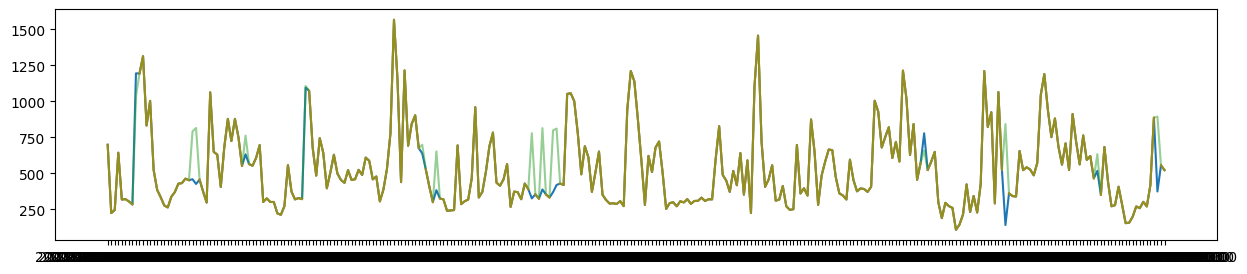

In [370]:
fig, ax = fig_ax()
ax.plot(data_train["holed_2"][0:300], alpha=1)
ax.plot(TS_missing["holed_2"][0:300])
ax.plot(interpolated_series["holed_2"][0:300], alpha=0.5)
plt.show()

## 7. SARIMAX

In [1050]:
pca_SARIMAX = PCA(n_components=60)
feature_pca_SARIMAX = pca_SARIMAX.fit_transform(df_test_complete) #pca.fit_transform(complete_TS)
feature_pca_SARIMAX = pd.DataFrame(feature_pca_SARIMAX, index=complete_TS.index, columns=[f"feature_{i}" for i in range(feature_pca_SARIMAX.shape[1])])

In [218]:
def sarimax_based_interpolation(holed_series, pca_series, order=(2,1,0), seasonal_order=(0,0,0,0)):
    """
    Interpolation des valeurs manquantes à l'aide de SARIMAX.
    
    - Entraîne un modèle SARIMAX sur les parties connues des séries.
    - Utilise les séries PCA comme exogènes pour améliorer la précision.
    
    Paramètres :
    - holed_series : DataFrame contenant les séries trouées.
    - pca_series : DataFrame contenant les séries PCA complètes.
    - order : Ordre du modèle SARIMA (p, d, q).
    - seasonal_order : Ordre saisonnier du modèle (P, D, Q, s).

    Retourne :
    - holed_series_interpolated : DataFrame avec les valeurs interpolées.
    """

    # 📌 S'assurer que les index sont bien alignés et de type DatetimeIndex
    if not isinstance(holed_series.index, pd.DatetimeIndex):
        holed_series.index = pd.to_datetime(holed_series.index)
        pca_series.index = pd.to_datetime(pca_series.index)
    holed_series_interpolated = holed_series.copy()
    # 📌 Aligner `holed_series` et `pca_series`
    pca_series = pca_series.reindex(holed_series.index)  # Force l'alignement des indices
    # 📌 Trouver les indices des valeurs manquantes
    missing_mask = holed_series.isna()

    # 📌 Supprimer les NaN pour entraîner le modèle
    train_data = holed_series.dropna()
    exog_train = pca_series.loc[train_data.index]
    # 📌 Vérifier que les indices sont bien alignés après `reindex()`
    if not train_data.index.equals(exog_train.index):
        raise ValueError("Les indices de `train_data` et `exog_train` ne sont pas alignés après `reindex()`")

    # 📌 Entraîner le modèle SARIMAX
    try:
        # model = SARIMAX(endog=train_data, exog=exog_train, order=order, seasonal_order=seasonal_order, trend='c')
        model = SARIMAX(endog=pca_series.iloc[:,0], order=order, seasonal_order=seasonal_order, trend='c')
        model_results = model.fit(disp=False)
        print('✅ Modèle entraîné avec trend "c"')
    except:
        # model = SARIMAX(endog=train_data, exog=exog_train, order=order, seasonal_order=seasonal_order, trend='n')
        model = SARIMAX(endog=pca_series.iloc[:,0], order=order, seasonal_order=seasonal_order, trend='n')
        model_results = model.fit(disp=False)
        print('⚠️ Trend "c" a échoué, modèle entraîné avec trend "n"')

    # 📌 Prédiction des valeurs manquantes
    for col in holed_series.columns:
        missing_idx = missing_mask[col][missing_mask[col]].index  # Indices des NaN

        for idx in missing_idx:
            # 📌 Vérifier que `idx` existe bien dans `pca_series`
            if idx not in pca_series.index:
                print(f"❌ Exogènes indisponibles pour {idx}, impossible de prédire {col}.")
                continue

            # 📌 Récupérer les features PCA associées à `idx`
            exog_data = pca_series.loc[[idx]].values  # Doit être sous forme de DataFrame (1, N)

            # 📌 Prédiction avec SARIMAX
            # prediction = model_results.forecast(steps=1, exog=exog_data)
            prediction = model_results.forecast(steps=1)

            # ✅ Correction : Convertir `prediction` en scalaire
            predicted_value = prediction.iloc[0] if isinstance(prediction, pd.Series) else prediction[0]
            # print(f"🔮 Prédiction pour {col} à {idx} : {predicted_value}")

            # 📌 Remplir la valeur prédite dans la série
            # print(holed_series_interpolated.loc[idx, col])
            holed_series_interpolated.loc[idx, col] = float(predicted_value)

    return holed_series_interpolated


In [219]:
interpolated_series = sarimax_based_interpolation(TS_missing[['holed_8']], feature_pca_SARIMAX, order=(1,1,0), seasonal_order=(3,0,0,49))

/Users/Mel/Desktop/Ecole_Inge/MFD/ML/Time_series_for_finance/MFD_ML_project/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency 30min will be used.
  self._init_dates(dates, freq)
/Users/Mel/Desktop/Ecole_Inge/MFD/ML/Time_series_for_finance/MFD_ML_project/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency 30min will be used.
  self._init_dates(dates, freq)


✅ Modèle entraîné avec trend "c"


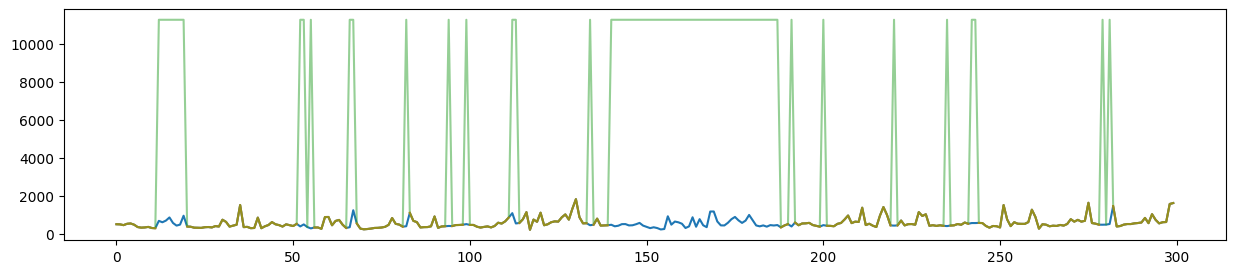

In [220]:
fig, ax = fig_ax()
ax.plot(data_train["holed_8"][100:400].values, alpha=1)
ax.plot(TS_missing["holed_8"][100:400].values)
ax.plot(interpolated_series["holed_8"][100:400].values, alpha=0.5)
plt.show()

In [1194]:
def interpolate_small_gaps(series):
    """
    Interpole linéairement toutes les séquences de NaN de taille 1 ou 2 dans une série Pandas.

    Paramètres :
    - series : pd.Series avec des valeurs NaN

    Retourne :
    - Une série avec interpolation linéaire pour les petites séquences de NaN
    """
    series_interpolated = series.copy()
    
    # Détecter les séquences de NaN
    missing_sequences = detect_missing_sequences(series)

    for start_idx, num_missing in missing_sequences:
        if num_missing <= 2:  # Interpolation uniquement pour 1 ou 2 NaN consécutifs
            series_interpolated.loc[start_idx:start_idx + pd.Timedelta(minutes=30 * (num_missing - 1))] = np.nan

    # Interpolation linéaire
    series_interpolated = series_interpolated.interpolate(method='linear')

    return series_interpolated

def varmax_based_interpolation(holed_series, pca_series, lag_order=5, verbose=True):
    """
    Applique l'interpolation avec un modèle VARMAX en utilisant les séries PCA comme variables exogènes.

    Paramètres :
    - holed_series : DataFrame (N, T) contenant les séries trouées.
    - pca_series : DataFrame (100, T) contenant les séries PCA complètes.
    - lag_order : Nombre de lags pour le modèle VARMAX.

    Retourne :
    - holed_series_interpolated : DataFrame avec les valeurs manquantes complétées.
    """

    # S'assurer que les index sont bien en DatetimeIndex
    holed_series.index = pd.to_datetime(holed_series.index)
    pca_series.index = pd.to_datetime(pca_series.index)

    # Conserver uniquement les timestamps communs
    common_index = holed_series.index.intersection(pca_series.index)
    holed_series = holed_series.loc[common_index]
    pca_series = pca_series.loc[common_index]
    
    holed_series_interpolated = holed_series.copy()
    if verbose:
        print(f"✅ Indices alignés, taille commune : {holed_series.shape[0]}")

    # Garder toutes les observations dans les séries endogènes, même avec NaN
    endog_data = holed_series.copy()

    # Supprimer les NaN uniquement dans les exogènes
    # exog_data = pca_series.dropna()

    # Aligner les exogènes avec les endogènes
    pca_series = pca_series.loc[endog_data.index]

    # Entraîner le modèle VARMAX avec exogènes
    varmax_model = SARIMAX(
        endog=endog_data.values, 
        exog=pca_series.values,
        order=(lag_order, 1, 1),  # VARMAX structure
        # seasonal_order=(1,0,0,49),
        enforce_stationarity=False,
        enforce_invertibility=False
    )

    try:
        varmax_results = varmax_model.fit(disp=False)
    except:
        warnings.simplefilter("ignore")
        print("⚠️ Problème avec le fit de VARMAX, tentative avec un lag_order réduit.")
        varmax_results = varmax_model.fit(disp=False,maxiter=500)

    for col in holed_series.columns:
        # holed_series_interpolated[col] = interpolate_small_gaps(holed_series[col])
        missing_sequences = detect_missing_sequences(holed_series[col])
        
        for start_idx, num_missing in missing_sequences:
            steps = num_missing
            
            # Récupérer les valeurs exogènes correspondantes pour la prédiction
            future_exog = pca_series.loc[start_idx:].iloc[:steps].values

            # Vérifier si on a assez de valeurs exogènes pour la prédiction
            if future_exog.shape[0] < steps:
                future_exog = np.pad(
                    future_exog, 
                    ((0, steps - future_exog.shape[0]), (0, 0)), 
                    mode='edge'
                )  # Remplissage avec la dernière valeur disponible

            # Prédire avec exogènes
            prediction = varmax_results.forecast(steps=steps, exog=future_exog)

            # Ajuster `num_missing` si nécessaire
            num_predicted = len(prediction)
            num_missing = min(num_missing, num_predicted)

            # Sélectionner les bons indices à remplacer
            missing_range = holed_series[col].loc[start_idx:].index[:num_missing]

            # Vérification avant affectation
            if len(missing_range) == num_missing:
                holed_series_interpolated.loc[missing_range, col] = prediction[:num_missing]
            else:
                print(f"⚠️ Problème d'alignement: {len(missing_range)} timestamps vs {num_missing} prédictions")
                
    return holed_series_interpolated


In [1195]:
serie = "holed_8"
y = TS_missing.loc[:,[serie]]
mean = y.mean()
y = y - mean
holed_series_interpolated = varmax_based_interpolation(y, feature_pca, lag_order=1)

✅ Indices alignés, taille commune : 1057


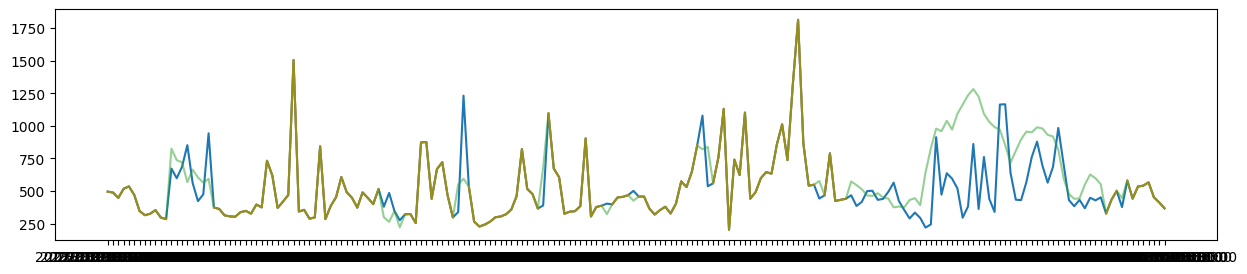

In [1196]:
fig, ax = fig_ax()
ax.plot(data_train[serie][100:300], alpha=1)
ax.plot(TS_missing[serie][100:300])
ax.plot(holed_series_interpolated.iloc[100:300].values+mean.values, alpha=0.5)
plt.show()

In [1197]:
serie_list_VARMAX = []
count = 0
serie_list = ['holed_8','holed_9']
for serie in tqdm(['holed_8','holed_9']):
    count += 1
    y = TS_missing.loc[:,[serie]]
    mean = y.mean()
    y = y - mean
    ts_interpolated = varmax_based_interpolation(y, feature_pca, lag_order=1, verbose=False).values
    ts_interpolated += mean.values  
    serie_list_VARMAX.append(ts_interpolated)
    # if count > 10:
    #     break
print(f"Il reste {np.isnan(serie_list_VARMAX).sum()} NaN")    

100%|██████████| 2/2 [00:05<00:00,  2.87s/it]

Il reste 0 NaN


In [1198]:
print(f"Il reste {np.isnan(serie_list_VARMAX).sum()} NaN")    

Il reste 0 NaN


In [1199]:
serie_list = ['holed_8','holed_9']

In [1200]:
serie_list_VARMAX = np.array(serie_list_VARMAX).squeeze()
missing_idx = np.isnan(TS_missing[serie_list].values)
mae = mean_absolute_error(data_train[serie_list].values[missing_idx], serie_list_VARMAX.T[missing_idx])
print(mae)

167.29141175803036


In [1201]:
mae_list = []
num_list = []
seq_count_list = []
for i in range(1,300):
    try:
        filtered_tab = filter_true_sequences(missing_idx, i)
        mae = mean_absolute_error(data_train[serie_list].values[filtered_tab], serie_list_VARMAX.T[filtered_tab])
        
        # Compter le nombre de séquences valides conservées
        # seq_count = sum(
        #     1 for j in range(filtered_tab.shape[1]) 
        #     if len(np.where(filtered_tab[:, j])[0]) == i
        # )
        
        mae_list.append(mae)
        num_list.append(i)
        # seq_count_list.append(seq_count)
    except Exception as e:
        pass

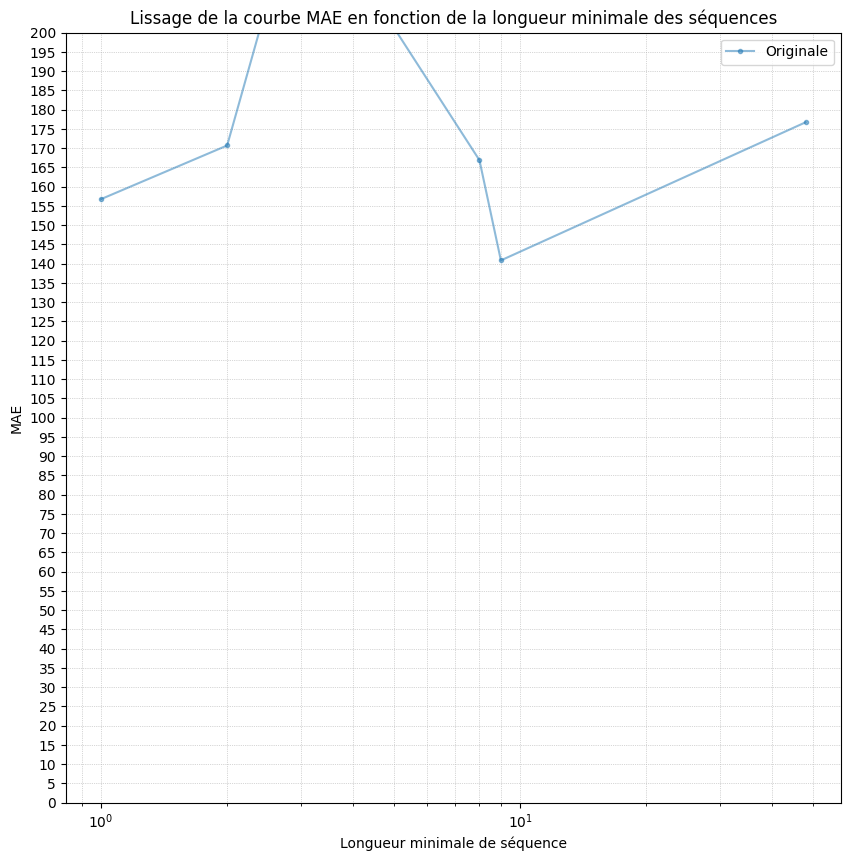

In [1202]:
# Appliquer un filtre gaussien pour lisser la courbe
smoothed_mae = gaussian_filter1d(mae_list, sigma=2)

# Tracer la courbe originale et lissée
plt.figure(figsize=(10, 10))
plt.plot(num_list, mae_list, label="Originale", alpha=0.5, marker=".")
# plt.plot(num_list, smoothed_mae, label="Lissée (Gaussien)", linewidth=2)

# Ajout des labels et du titre
plt.xlabel("Longueur minimale de séquence")
plt.ylabel("MAE")
plt.title("Lissage de la courbe MAE en fonction de la longueur minimale des séquences")
plt.legend()
plt.ylim((0,200))
# Échelle logarithmique pour l'axe X
plt.xscale('log')

# Ajouter plus de graduations sur l'axe Y
ax = plt.gca()  # Récupérer l'axe courant
ax.yaxis.set_major_locator(ticker.MultipleLocator(5))  # Graduation principale tous les 2
# ax.yaxis.set_minor_locator(ticker.MultipleLocator(0))  # Graduation mineure tous les 1
ax.grid(which='both', linestyle=':', linewidth=0.5)  # Ajouter une grille pour plus de clarté
plt.savefig('plots_raport/VARMA_Analysis.png', dpi=500)

plt.show()


## 8. LSTM

In [467]:
def detect_missing_sequences(series):
    """
    Détecte les séquences de valeurs manquantes consécutives.
    
    Retourne une liste de tuples (start_idx, end_idx) indiquant les blocs de NaN.
    """
    missing_sequences = []
    in_missing_block = False

    for i in range(len(series)):
        if np.isnan(series[i]) and not in_missing_block:
            start_idx = i
            in_missing_block = True
        elif not np.isnan(series[i]) and in_missing_block:
            end_idx = i - 1
            missing_sequences.append((start_idx, end_idx))
            in_missing_block = False

    # Si la série se termine par des NaN
    if in_missing_block:
        missing_sequences.append((start_idx, len(series) - 1))

    return missing_sequences

def prepare_lstm_data(holed_series, pca_series, lookback=10):
    """
    Prépare les données pour entraîner la LSTM.

    - Construit des séquences temporelles (`lookback` timesteps).
    - Normalise les données.
    
    Retourne :
    - X_train, y_train : Données d'entraînement.
    - X_test, missing_idx : Données pour prédire les valeurs manquantes.
    - scaler : Scaler utilisé pour la normalisation.
    """

    # Concaténer les séries trouées et les PCA
    combined_data = pd.concat([holed_series, pca_series], axis=1) # (T, N)

    # Normalisation des données
    scaler = MinMaxScaler()
    combined_data_scaled = pd.DataFrame(scaler.fit_transform(combined_data), 
                                        columns=combined_data.columns, 
                                        index=combined_data.index)

    X_train, y_train = [], []

    for col in holed_series.columns:
        series = combined_data_scaled[col].values  # 📌 Seule la série cible est prise dans `y_train`
        missing_sequences = detect_missing_sequences(holed_series[col].values)

        for i in range(lookback, len(series)):
            if any(start <= i <= end for start, end in missing_sequences):
                continue  # On ne prend pas les NaN pour l'entraînement

            # 📌 Construire `X_train` avec les valeurs passées de `holed_series` ET `pca_series`
            past_values = combined_data_scaled.iloc[i-lookback:i].values  # (lookback, N)
            if np.isnan(past_values).any():
                continue
            pca_features = pca_series.iloc[i-lookback:i].values  # (N_pca,)
            full_features = np.concatenate([past_values.flatten(), pca_features.flatten()])  # (lookback * N + N_pca,)
            print(full_features.shape)
            if np.isnan(full_features).any():
                print(i)
            X_train.append(full_features)
            y_train.append(series[i])  # 📌 `y_train` contient uniquement `holed_series[col]`

    return np.array(X_train), np.array(y_train), scaler

def build_lstm_model(input_shape):
    """
    Construit un modèle LSTM pour interpoler les valeurs manquantes.
    """
    model = Sequential([
        LSTM(50, return_sequences=True, input_shape=input_shape),
        LSTM(50, return_sequences=False),
        Dense(25, activation='relu'),
        Dense(1)
    ])
    
    model.compile(optimizer='adam', loss='mae')
    return model

def lstm_interpolation(holed_series, pca_series, lookback=10, epochs=20, batch_size=16):
    """
    Applique une interpolation basée sur un modèle LSTM en prenant en compte toutes les séries trouées + PCA.

    - Entraîne un modèle sur les données connues.
    - Prédit les valeurs manquantes séquentiellement en utilisant toutes les séries trouées et les PCA.

    Retourne :
    - holed_series_interpolated : DataFrame avec les valeurs complétées.
    """

    holed_series_interpolated = holed_series.copy()

    # 📌 Préparation des données
    X_train, y_train, scaler = prepare_lstm_data(holed_series, pca_series, lookback)

    # ✅ Stocker l'ordre des colonnes après le fit
    expected_columns = list(pd.concat([holed_series, pca_series], axis=0).columns)

    # 📌 Vérifier si on a des données d'entraînement valides
    if len(X_train) < 2:
        print("⚠️ Pas assez de données pour entraîner la LSTM.")
        return holed_series_interpolated

    # 📌 Construire et entraîner le modèle LSTM
    model = build_lstm_model((X_train.shape[1], 1))
    model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, verbose=1)

    # 📌 Interpolation séquentielle bloc par bloc
    for col in holed_series.columns:
        missing_sequences = detect_missing_sequences(holed_series[col].values)

        for start_idx, end_idx in missing_sequences:
            if start_idx > lookback:
                for idx in range(start_idx, end_idx + 1):
                    # 📌 Récupérer les valeurs passées de toutes les séries trouées
                    input_sequence = holed_series_interpolated.iloc[idx - lookback:idx].values
                    print(start_idx)
                    # 📌 Si NaN présents, remplir avec la moyenne des valeurs connues
                    nan_mask = np.isnan(input_sequence)
                    if np.any(nan_mask):
                        mean_values = np.nanmean(holed_series_interpolated.iloc[:idx].values, axis=0)
                        input_sequence[nan_mask] = np.take(mean_values, np.where(nan_mask)[1])

                    # 📌 Ajouter les valeurs PCA correspondantes
                    pca_features = pca_series.iloc[idx - lookback:idx].values
                    
                    # 📌 Construire le DataFrame avec toutes les séries trouées + PCA
                    # print(input_sequence.flatten().shape, pca_features.shape)
                    full_features = np.concatenate([input_sequence.flatten(), pca_features.flatten()])
                    # print(full_features)
                    # full_features_df = pd.DataFrame(full_features, columns=expected_columns)

                    # ✅ Vérifier que les colonnes sont bien dans le bon ordre
                    # full_features_df = full_features_df.reindex(columns=expected_columns, fill_value=0)

                    # 📌 Normaliser l'entrée
                    full_features_scaled = scaler.transform(full_features)
                    input_sequence_scaled = np.array(full_features_scaled).reshape((1, X_train.shape[1], 1))

                    # 📌 Prédire la valeur manquante
                    pred_scaled = model.predict(input_sequence_scaled)
                    pred = scaler.inverse_transform([[pred_scaled[0, 0]]])[0, 0]

                    # 📌 Remplir la valeur prédite dans la série
                    holed_series_interpolated.loc[idx, col] = pred

    return holed_series_interpolated

In [459]:
holed_series = TS_missing[['holed_1','holed_2']].copy()
pca = PCA(n_components=20)
test_pca = pca.fit_transform(df_test_complete)
test_pca = pd.DataFrame(test_pca, index=holed_series.index, columns=[f"feature_{i}" for i in range(test_pca.shape[1])])

In [468]:
holed_series_interpolated = lstm_interpolation(holed_series,test_pca, 10, 1, 16)

(420,)
(420,)
(420,)
(420,)
(420,)
(420,)
(420,)
(420,)
(420,)
(420,)
(420,)
(420,)
(420,)
(420,)
(420,)
(420,)
(420,)
(420,)
(420,)
(420,)
(420,)
(420,)
(420,)
(420,)
(420,)
(420,)
(420,)
(420,)
(420,)
(420,)
(420,)
(420,)
(420,)
(420,)
(420,)
(420,)
(420,)
(420,)
(420,)
(420,)
(420,)
(420,)
(420,)
(420,)
(420,)
(420,)
(420,)
(420,)
(420,)
(420,)
(420,)
(420,)
(420,)
(420,)
(420,)
(420,)
(420,)
(420,)
(420,)
(420,)
(420,)
(420,)
(420,)
(420,)
(420,)
(420,)
(420,)
(420,)
(420,)
(420,)
(420,)
(420,)
(420,)
(420,)
(420,)
(420,)
(420,)
(420,)
(420,)
(420,)
(420,)
(420,)
(420,)
(420,)
(420,)
(420,)
(420,)
(420,)
(420,)
(420,)
(420,)
(420,)
(420,)
(420,)
(420,)
(420,)
(420,)
(420,)
(420,)
(420,)
(420,)
(420,)
(420,)
(420,)
(420,)
(420,)
(420,)
(420,)
(420,)
(420,)
(420,)
(420,)
(420,)
(420,)
(420,)
(420,)
(420,)
(420,)
(420,)
(420,)
(420,)
(420,)
(420,)
(420,)
(420,)
(420,)
(420,)
(420,)
(420,)
(420,)
(420,)
(420,)
(420,)
(420,)
(420,)
(420,)
(420,)
(420,)
(420,)
(420,)
(420,)
(420,)
(420,)

/Users/Mel/Desktop/Ecole_Inge/MFD/ML/Time_series_for_finance/MFD_ML_project/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


KeyboardInterrupt: 

In [11]:
pca = PCA(n_components=60)
feature_pca = pca.fit_transform(df_test_complete) #pca.fit_transform(complete_TS)
feature_pca = pd.DataFrame(feature_pca, index=complete_TS.index, columns=[f"feature_{i}" for i in range(feature_pca.shape[1])])

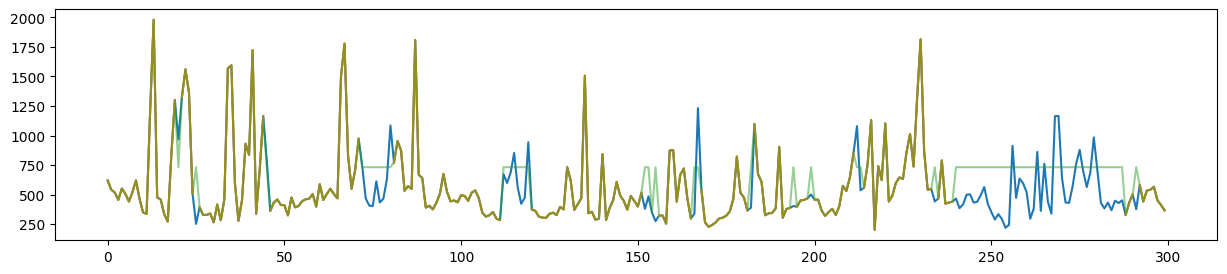

In [16]:
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler

# def gaussian_process_interpolation(series):
#     """Interpole les valeurs manquantes d'une série avec un Gaussian Process."""
#     series.index = pd.to_datetime(series.index)  # Assurer un index datetime
#     timestamps = series.index.astype(np.int64) // 10**9  # Convertir en timestamps UNIX

#     known_idx = np.array(timestamps[~np.isnan(series.values)], dtype=np.float64)
#     known_values = series.dropna().values.astype(np.float64)
#     missing_idx = np.array(timestamps[np.isnan(series.values)], dtype=np.float64)

#     if known_idx.size == 0 or missing_idx.size == 0:
#         return series  # Rien à interpoler

#     gpr = GaussianProcessRegressor(kernel=1.0 * RBF(length_scale=5.0), alpha=1e-2, normalize_y=True)
#     gpr.fit(known_idx.reshape(-1, 1), known_values)
#     series.loc[series.index.isin(pd.to_datetime(missing_idx, unit='s'))] = gpr.predict(missing_idx.reshape(-1, 1))
    
#     return series

def gaussian_process_interpolation(series, feature_pca):
    """Interpole les valeurs manquantes d'une série avec un Gaussian Process."""
    series = series.values
    known_idx = np.where(~np.isnan(series))[0]
    known_values = series[known_idx]
    missing_idx = np.where(np.isnan(series))[0]
    scaler = StandardScaler()
    known_values_scaled = scaler.fit_transform(known_values.reshape(-1, 1)).ravel()
    gpr = GaussianProcessRegressor(kernel=1.0 * RBF(length_scale=50.0), alpha=1e-2, normalize_y=True)
    gpr.fit(feature_pca.values[~np.isnan(series)], known_values_scaled)
    predicted_scaled = gpr.predict(feature_pca.values[np.isnan(series)])
    predicted = scaler.inverse_transform(predicted_scaled.reshape(-1, 1)).ravel()
    series[missing_idx] = predicted
    
    return series

serie = "holed_8"

# Appliquer sur les séries interpolées
holed_series_interpolated = gaussian_process_interpolation(TS_missing[serie].copy(), feature_pca)
fig, ax = fig_ax()
ax.plot(data_train[serie].values[0:300], alpha=1)
ax.plot(TS_missing[serie].values[0:300])
ax.plot(holed_series_interpolated[0:300], alpha=0.5)
plt.show()

In [13]:
serie_list_GPR = []
Test_series_ = []
for serie in tqdm(test_series):
    y = TS_missing.loc[:,serie].copy()
    try:
        ts_interpolated = gaussian_process_interpolation(y.copy(), feature_pca.copy())
        ts_interpolated += mean 
        serie_list_GPR.append(ts_interpolated)
        Test_series_.append(serie)
    except:
        pass 
print(f"Il reste {np.isnan(serie_list_GPR).sum()} NaN")  

  0%|          | 0/200 [00:00<?, ?it/s]

100%|██████████| 200/200 [00:50<00:00,  3.98it/s]

Il reste 0 NaN


In [14]:
len(serie_list_GPR)

0

In [15]:
serie_list_GPR = np.array(serie_list_GPR).squeeze()
missing_idx = np.isnan(TS_missing[Test_series_].values)
mae = mean_absolute_error(data_train[Test_series_].values[missing_idx], serie_list_GPR.T[missing_idx])
print(mae)

IndexError: too many indices for array: array is 1-dimensional, but 2 were indexed

In [1370]:
mae_list = []
num_list = []
seq_count_list = []
for i in range(1,300):
    try:
        filtered_tab = filter_true_sequences(missing_idx, i)
        mae = mean_absolute_error(data_train[Test_series_].values[filtered_tab], serie_list_GPR.T[filtered_tab])
        
        # Compter le nombre de séquences valides conservées
        seq_count = sum(
            1 for j in range(filtered_tab.shape[1]) 
            if len(np.where(filtered_tab[:, j])[0]) == i
        )
        
        mae_list.append(mae)
        num_list.append(i)
        seq_count_list.append(seq_count)
    except:
        pass

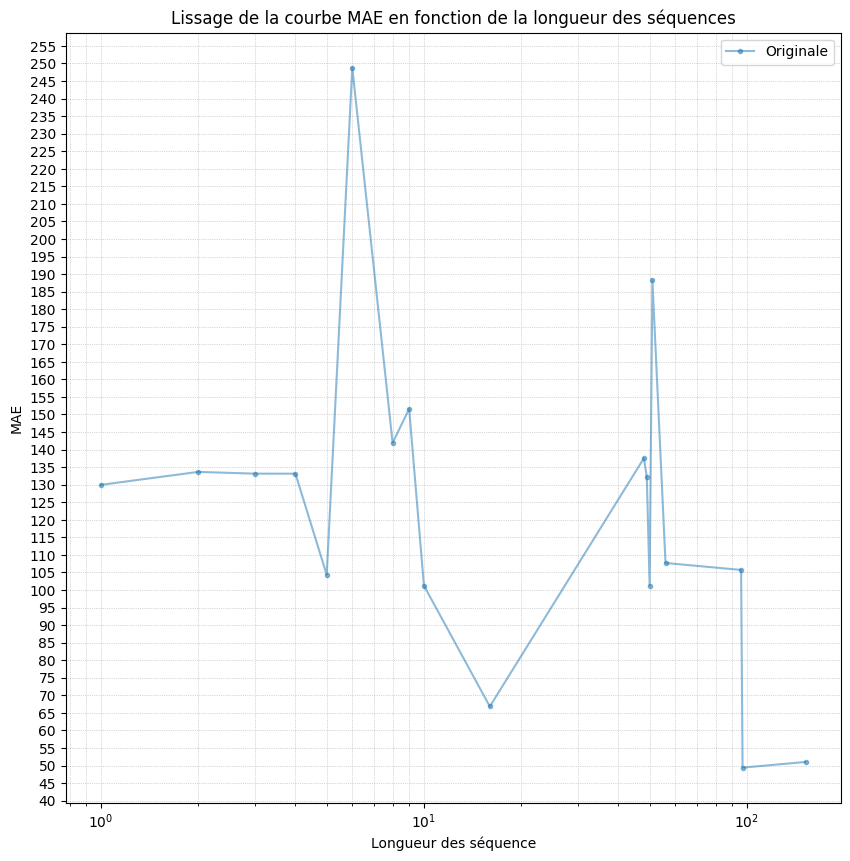

In [1371]:
# Appliquer un filtre gaussien pour lisser la courbe
smoothed_mae = gaussian_filter1d(mae_list, sigma=2)

# Tracer la courbe originale et lissée
plt.figure(figsize=(10, 10))
plt.plot(num_list, mae_list, label="Originale", alpha=0.5, marker=".")
# plt.plot(num_list, smoothed_mae, label="Lissée (Gaussien)", linewidth=2)

# Ajout des labels et du titre
plt.xlabel("Longueur des séquence")
plt.ylabel("MAE")
plt.title("Lissage de la courbe MAE en fonction de la longueur des séquences")
plt.legend()

# Échelle logarithmique pour l'axe X
plt.xscale('log')

# Ajouter plus de graduations sur l'axe Y
ax = plt.gca()  # Récupérer l'axe courant
ax.yaxis.set_major_locator(ticker.MultipleLocator(5))  # Graduation principale tous les 2
# ax.yaxis.set_minor_locator(ticker.MultipleLocator(0))  # Graduation mineure tous les 1
ax.grid(which='both', linestyle=':', linewidth=0.5)  # Ajouter une grille pour plus de clarté
plt.savefig('plots_raport/VAR_Analysis_mixed.png', dpi=500)

plt.show()



## 9. Tree Based

In [193]:
from xgboost import XGBRegressor

In [733]:
pca = PCA(n_components=60)
feature_pca = pca.fit_transform(df_test_complete) #pca.fit_transform(complete_TS)
feature_pca = pd.DataFrame(feature_pca, index=complete_TS.index, columns=[f"feature_{i}" for i in range(feature_pca.shape[1])])
temp = feature_pca.index
feature_pca.index = pd.to_datetime(feature_pca.index)
# feature_pca["day_of_week"] = feature_pca.index.dayofweek  # Jour de la semaine (0 = Lundi, 6 = Dimanche)
# feature_pca["hour"] = feature_pca.index.hour  # Heure si fréquence intraday
# feature_pca["month"] = feature_pca.index.month  # Mois
# Périodes à utiliser pour l'encodage

# Ajout des colonnes encodées avec sin et cos
feature_pca['sin_year'] = np.sin(2 * np.pi * feature_pca.index.days_in_month / 31)
feature_pca['cos_year'] = np.cos(2 * np.pi * feature_pca.index.days_in_month / 31)

feature_pca['sin_week'] = np.sin(2 * np.pi * feature_pca.index.dayofweek / 7)
feature_pca['cos_week'] = np.cos(2 * np.pi * feature_pca.index.dayofweek / 7)

# Encodage cyclique des heures (24h = 1 cycle complet)
feature_pca["hour_sin"] = np.sin(2 * np.pi * feature_pca.index.hour / 24)
feature_pca["hour_cos"] = np.cos(2 * np.pi * feature_pca.index.hour / 24)

# Encodage cyclique des minutes (60 min = 1 cycle complet)
# feature_pca["minute_sin"] = np.where(np.sin(2 * np.pi * feature_pca.index.minute / 60)>0,1,0)
# feature_pca["minute_cos"] = np.cos(2 * np.pi * feature_pca.index.minute / 60)
feature_pca['minute'] = np.array(feature_pca.index.minute)
feature_pca.index = temp
feature_pca.head()

,feature_0,feature_1,feature_2,feature_3,feature_4,feature_5,feature_6,feature_7,feature_8,feature_9,...,feature_57,feature_58,feature_59,sin_year,cos_year,sin_week,cos_week,hour_sin,hour_cos,minute
Horodate,,,,,,,,,,,,,,,,,,,,,
2023-01-09 00:00:00,-25856.843481,19083.073312,-11412.651173,-4753.162365,-4151.186820,-7914.224336,6504.944130,-2683.674003,2904.774342,11100.808790,...,-3615.866082,2017.695533,-1741.477427,-2.449294e-16,1.0,0.0,1.0,0.000000,1.000000,0
2023-01-09 00:30:00,-27215.683251,19324.017477,-8413.899442,-3486.260044,-4401.667405,-5994.585550,8764.790827,-4138.393498,3612.405146,10118.080308,...,-2235.607827,2738.475594,-360.154831,-2.449294e-16,1.0,0.0,1.0,0.000000,1.000000,30
2023-01-09 01:00:00,-28829.713192,18679.817680,-3772.600132,559.605766,-4800.692075,-3131.299125,10711.855685,-4611.370287,3445.004748,6516.487775,...,583.712956,1068.838578,2121.201588,-2.449294e-16,1.0,0.0,1.0,0.258819,0.965926,0
2023-01-09 01:30:00,-29753.089982,17644.940864,1279.580673,3985.666958,-4079.146041,-217.299224,11771.633826,-5509.795911,1525.808370,3688.934174,...,1129.054000,2103.938624,1434.544702,-2.449294e-16,1.0,0.0,1.0,0.258819,0.965926,30
2023-01-09 02:00:00,-28382.902443,17045.986468,6716.731995,6834.332989,-2988.195354,3912.338621,11387.613189,-5162.090136,-1144.536589,1684.237466,...,1511.254966,2081.408003,-2150.912000,-2.449294e-16,1.0,0.0,1.0,0.500000,0.866025,0


In [720]:
def fill_past_data(combined_data, idx, lag_order):
    """
    Remplit past_data avec les valeurs les plus récentes possibles avant idx.
    Si pas assez, complète avec les valeurs après idx.
    
    Paramètres :
    - combined_data : DataFrame (T, N) avec les séries trouées et PCA.
    - idx : Index où l'on veut prédire.
    - lag_order : Nombre de lags nécessaires.

    Retourne :
    - past_data : Tableau numpy (lag_order, N) prêt pour la prédiction.
    """
    past_values = combined_data.loc[:idx].dropna().iloc[-lag_order:].values

    if past_values.shape[0] < lag_order:  # Si pas assez de valeurs avant
        missing = lag_order - past_values.shape[0]
        future_values = combined_data.loc[idx:].dropna().iloc[:missing].values

        # Concaténer valeurs avant et après si possible
        past_values = np.vstack([past_values, future_values]) if future_values.shape[0] > 0 else past_values

    # Si encore pas assez de données, on répète la dernière valeur connue
    if past_values.shape[0] < lag_order:
        past_values = np.pad(past_values, ((lag_order - past_values.shape[0], 0), (0, 0)), mode='edge')

    return past_values

def detect_missing_sequences(series):
    """
    Détecte les séquences de valeurs manquantes dans une série temporelle.
    Retourne une liste de tuples (start_idx, num_missing) indiquant les plages de NaN.
    """
    missing_sequences = []
    is_missing = series.isna()
    
    i = 0
    while i < len(series):
        if is_missing.iloc[i]:  # Début d'une séquence de NaN
            start_idx = series.index[i]
            num_missing = 1
            
            # Parcourir la suite tant qu'on est sur des NaN
            while i + num_missing < len(series) and is_missing.iloc[i + num_missing]:
                num_missing += 1

            # Sauvegarder la séquence trouvée
            missing_sequences.append((start_idx, num_missing))

            # Avancer à la fin de la séquence actuelle
            i += num_missing
        else:
            i += 1  # Passer aux prochaines valeurs

    return missing_sequences

def tree_based_interpolation(holed_series, pca_series):
    """
    Applique l'interpolation VAR en utilisant les séries PCA comme contraintes.

    Paramètres :
    - holed_series : DataFrame (N, T) contenant les séries trouées.
    - pca_series : DataFrame (100, T) contenant les séries PCA complètes.
    - lag_order : Nombre de lags pour le modèle VAR.

    Retourne :
    - holed_series_interpolated : DataFrame avec les valeurs manquantes complétées.
    """

    holed_series_interpolated = holed_series.copy()

    # temp = holed_series.copy()
    # temp["seq_length"] = holed_series.index.to_series().diff().fillna(1).astype(int)
    # temp["prev_value"] = holed_series.shift(1)
    # temp["next_value"] = holed_series.shift(-1)
    # holed_series.interpolate(method="linear", limit=6, limit_direction="both", inplace=True, axis=0)
    # Concaténer les séries trouées et les séries PCA pour le modèle VAR
    combined_data = pd.concat([holed_series, pca_series], axis=1)  # Transpose pour avoir (T, N)
    # Construire le dataset d'entraînement sur les valeurs connues
    X_train = combined_data.dropna().drop(columns=holed_series.columns)  # Variables exogènes
    y_train = combined_data.dropna()[holed_series.columns]  # Valeurs à prédire

    # Entraîner XGBoost
    xgb_model = XGBRegressor(n_estimators=150, max_depth=3, learning_rate=0.1, objective="reg:absoluteerror")
    xgb_model.fit(X_train, y_train)

    # Appliquer XGBoost sur les trous longs
    for col in holed_series.columns:
        missing_sequences = detect_missing_sequences(holed_series[col])
        for start_idx, num_missing in missing_sequences:
            if num_missing > 3:  # Seulement pour les trous longs
                missing_range = holed_series[col].loc[start_idx:].index[:num_missing]
                X_pred = combined_data.loc[missing_range].drop(columns=holed_series.columns)
                prediction_xgb = xgb_model.predict(X_pred)

                holed_series_interpolated.loc[missing_range, col] = prediction_xgb
            else:
                missing_range = holed_series[col].loc[start_idx:].index[:num_missing]
                holed_series_interpolated.loc[missing_range, col] = holed_series_interpolated.interpolate(method="linear", limit_direction="both", axis=0).loc[missing_range, col]

    return holed_series_interpolated

In [735]:
from scipy.stats import pearsonr

def fill_past_data(combined_data, idx, lag_order):
    """
    Remplit past_data avec les valeurs les plus récentes possibles avant idx.
    Si pas assez, complète avec les valeurs après idx.
    
    Paramètres :
    - combined_data : DataFrame (T, N) avec les séries trouées et PCA.
    - idx : Index où l'on veut prédire.
    - lag_order : Nombre de lags nécessaires.

    Retourne :
    - past_data : Tableau numpy (lag_order, N) prêt pour la prédiction.
    """
    past_values = combined_data.loc[:idx].dropna().iloc[-lag_order:].values
    
    if past_values.shape[0] < lag_order:  # Si pas assez de valeurs avant
        missing = lag_order - past_values.shape[0]
        future_values = combined_data.loc[idx:].dropna().iloc[:missing].values

        # Concaténer valeurs avant et après si possible
        past_values = np.vstack([past_values, future_values]) if future_values.shape[0] > 0 else past_values

    # Si encore pas assez de données, on répète la dernière valeur connue
    if past_values.shape[0] < lag_order:
        past_values = np.pad(past_values, ((lag_order - past_values.shape[0], 0), (0, 0)), mode='edge')

    return past_values

def detect_missing_sequences(series):
    """
    Détecte les séquences de valeurs manquantes dans une série temporelle.
    Retourne une liste de tuples (start_idx, num_missing) indiquant les plages de NaN.
    """
    missing_sequences = []
    is_missing = series.isna()
    
    i = 0
    while i < len(series):
        if is_missing.iloc[i]:  # Début d'une séquence de NaN
            start_idx = series.index[i]
            num_missing = 1
            
            # Parcourir la suite tant qu'on est sur des NaN
            while i + num_missing < len(series) and is_missing.iloc[i + num_missing]:
                num_missing += 1

            # Sauvegarder la séquence trouvée
            missing_sequences.append((start_idx, num_missing))

            # Avancer à la fin de la séquence actuelle
            i += num_missing
        else:
            i += 1  # Passer aux prochaines valeurs

    return missing_sequences

def tree_based_interpolation(holed_series, pca_series):
    """
    Applique l'interpolation VAR en utilisant les séries PCA comme contraintes.

    Paramètres :
    - holed_series : DataFrame (N, T) contenant les séries trouées.
    - pca_series : DataFrame (100, T) contenant les séries PCA complètes.
    - lag_order : Nombre de lags pour le modèle VAR.

    Retourne :
    - holed_series_interpolated : DataFrame avec les valeurs manquantes complétées.
    """

    holed_series_interpolated = holed_series.copy()
    # pca_series_filtered = pd.DataFrame([])
    # for i in range(len(pca_series.columns)):
    #     try:
    #         valid_values = holed_series.iloc[:,0].dropna().index.intersection(pca_series.iloc[:,i].dropna().index)
    #         corr, p_value = pearsonr(holed_series.iloc[:,0].dropna().loc[valid_values], pca_series.iloc[:,i].loc[valid_values])
    #         if "feature" not in pca_series.columns[i] or abs(corr) > 0.01:
    #             pca_series_filtered = pd.concat([pca_series_filtered,pca_series.iloc[:,i]], axis=1)
    #     except:
    #         pca_series_filtered = pd.concat([pca_series_filtered,pca_series.iloc[:,i]], axis=1)
    # print(pca_series_filtered.shape)
    # m = holed_series.shift(10).fillna(-1).rename(columns={holed_series.columns[0]:"m"})
    combined_data = pd.concat([holed_series, pca_series], axis=1)

    # Construire le dataset d'entraînement sur les valeurs connues
    X_train = combined_data.dropna().drop(columns=holed_series.columns)  # Variables exogènes
    y_train = combined_data.dropna()[holed_series.columns]  # Valeurs à prédire

    # Entraîner XGBoost
    xgb_model = XGBRegressor(n_estimators=150, max_depth=4, learning_rate=0.1, objective="reg:absoluteerror", colsample_bytree=0.8)
    xgb_model.fit(X_train, y_train)

    # Appliquer XGBoost sur les trous longs
    for col in holed_series.columns:
        missing_sequences = detect_missing_sequences(holed_series[col])
        for start_idx, num_missing in missing_sequences:
            if num_missing > 3:  # Seulement pour les trous longs
                missing_range = holed_series[col].loc[start_idx:].index[:num_missing]
                X_pred = combined_data.loc[missing_range].drop(columns=holed_series.columns)
                prediction_xgb = xgb_model.predict(X_pred)

                holed_series_interpolated.loc[missing_range, col] = prediction_xgb
            else:
                missing_range = holed_series[col].loc[start_idx:].index[:num_missing]
                holed_series_interpolated.loc[missing_range, col] = holed_series_interpolated.interpolate(method="linear", limit_direction="both", axis=0).loc[missing_range, col]

    return holed_series_interpolated

In [736]:
serie = "holed_8"
y = TS_missing.loc[:,[serie]]
mean = y.mean()
y = y - mean
holed_series_interpolated = tree_based_interpolation(y.copy(), feature_pca)

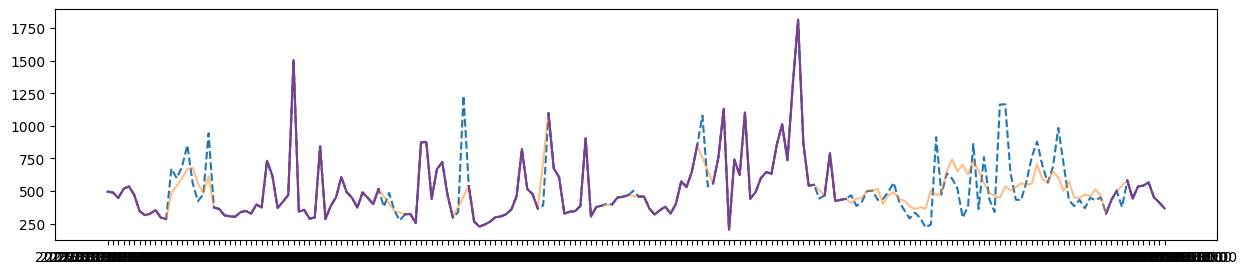

158.60885657832154


In [737]:
fig, ax = fig_ax()
ax.plot(data_train[serie][100:300], alpha=1, linestyle="--")
ax.plot(TS_missing[serie][100:300], color='blue')
ax.plot(holed_series_interpolated.iloc[100:300].values+mean.values, alpha=0.5)
plt.show()
missing_idx = np.isnan(TS_missing[serie].values)
mae = mean_absolute_error(data_train[serie].values[missing_idx], holed_series_interpolated[serie].values[missing_idx]+mean.values)
print(mae)

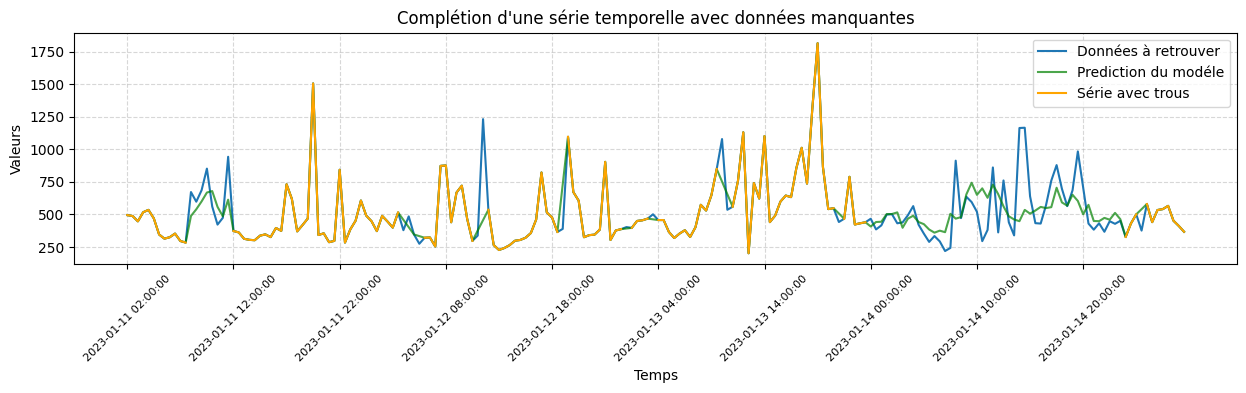

In [738]:
fig, ax = fig_ax()
ax.plot(data_train["holed_8"][100:300], alpha=1, label='Données à retrouver')
ax.plot(holed_series_interpolated.iloc[100:300].values+mean.values, alpha=0.7, label='Prediction du modéle', color='green')
ax.plot(TS_missing["holed_8"][100:300], label='Série avec trous', color="orange")
ax.set_xticks(range(0, 200, 20))  # Affichage tous les 10 points
ax.set_xticklabels(data_train.index[100:300:20], rotation=45, fontsize=8)  # Rotation pour lisibilité
ax.set_title("Complétion d'une série temporelle avec données manquantes")
ax.set_xlabel("Temps")
ax.set_ylabel("Valeurs")

# Ajout d'une grille légère
ax.grid(True, linestyle='--', alpha=0.5)

# Ajout d'une légende
ax.legend()
plt.savefig('plots_raport/tree_mixed.png', dpi=500)
plt.show()

In [739]:
serie_list_VAR = []

for serie in tqdm(holed_T_train):
    y = TS_missing.loc[:,[serie]]
    mean = y.mean()
    y = y - mean
    # ts_interpolated = var_based_interpolation(y, feature_pca, lag_order=int(1*longest_missing_segment(y))).values
    ts_interpolated = tree_based_interpolation(y, feature_pca).values
    ts_interpolated += mean.values  
    serie_list_VAR.append(ts_interpolated)
print(f"Il reste {np.isnan(serie_list_VAR).sum()} NaN")    

100%|██████████| 999/999 [05:35<00:00,  2.98it/s]

Il reste 0 NaN


In [741]:
serie_list_VAR = np.array(serie_list_VAR).squeeze()
missing_idx = np.isnan(TS_missing[holed_T_train].values)
mae = mean_absolute_error(data_train[holed_T_train].values[missing_idx], serie_list_VAR.T[missing_idx])
print(mae)

78.29440345507273


In [707]:
# SANS filtrage
serie_list_VAR = np.array(serie_list_VAR).squeeze()
missing_idx = np.isnan(TS_missing[test_series].values)
mae = mean_absolute_error(data_train[test_series].values[missing_idx], serie_list_VAR.T[missing_idx])
print(mae)

72.38739175270825


In [57]:
serie_list_VAR = np.array(serie_list_VAR).squeeze()
missing_idx = np.isnan(TS_missing[test_series].values)
mae = mean_absolute_error(data_train[test_series].values[missing_idx], serie_list_VAR.T[missing_idx])
print(mae)

71.97359003649433


In [696]:
def filter_true_sequences(arr: np.ndarray, min_length: int) -> np.ndarray:
    """
    Conserve uniquement les séquences de True d'une longueur donnée dans un tableau numpy 2D,
    en remplaçant les autres valeurs par False. La vérification se fait uniquement sur les colonnes.
    
    :param arr: np.ndarray booléen 2D contenant des True et False
    :param min_length: Longueur minimale des séquences de True à conserver
    :return: Nouveau tableau avec uniquement les séquences valides conservées
    """
    result = np.zeros_like(arr, dtype=bool)
    
    # Parcours des colonnes
    for j in range(arr.shape[1]):
        true_indices = np.where(arr[:, j])[0]  # Indices des True
        if len(true_indices) > 0:
            splits = np.split(true_indices, np.where(np.diff(true_indices) != 1)[0] + 1)  # Séquences continues
            for seq in splits:
                if len(seq) == min_length:
                    result[seq, j] = True
    
    return result

mae_list = []
num_list = []
seq_count_list = []
for i in range(1,300):
    try:
        filtered_tab = filter_true_sequences(missing_idx, i)
        mae = mean_absolute_error(data_train[test_series].values[filtered_tab], serie_list_VAR.T[filtered_tab])
        
        # Compter le nombre de séquences valides conservées
        seq_count = sum(
            1 for j in range(filtered_tab.shape[1]) 
            if len(np.where(filtered_tab[:, j])[0]) == i
        )
        
        mae_list.append(mae)
        num_list.append(i)
        seq_count_list.append(seq_count)
    except:
        pass

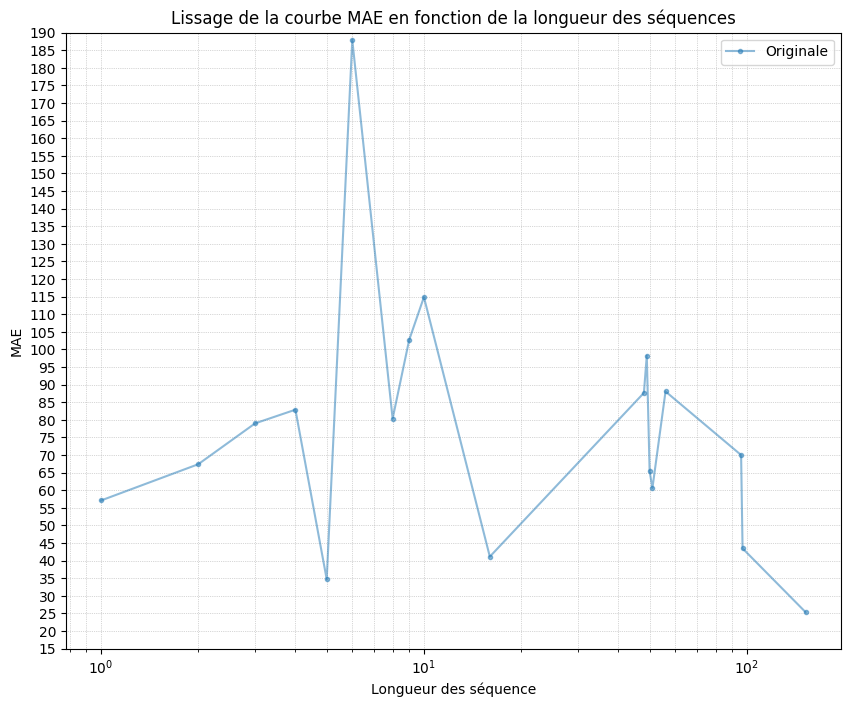

In [697]:
# Appliquer un filtre gaussien pour lisser la courbe
smoothed_mae = gaussian_filter1d(mae_list, sigma=2)

# Tracer la courbe originale et lissée
plt.figure(figsize=(10, 8))
plt.plot(num_list, mae_list, label="Originale", alpha=0.5, marker=".")
# plt.plot(num_list, smoothed_mae, label="Lissée (Gaussien)", linewidth=2)

# Ajout des labels et du titre
plt.xlabel("Longueur des séquence")
plt.ylabel("MAE")
plt.title("Lissage de la courbe MAE en fonction de la longueur des séquences")
plt.legend()
plt.ylim((15,190))
# Échelle logarithmique pour l'axe X
plt.xscale('log')

# Ajouter plus de graduations sur l'axe Y
ax = plt.gca()  # Récupérer l'axe courant
ax.yaxis.set_major_locator(ticker.MultipleLocator(5))  # Graduation principale tous les 2
# ax.yaxis.set_minor_locator(ticker.MultipleLocator(0))  # Graduation mineure tous les 1
ax.grid(which='both', linestyle=':', linewidth=0.5)  # Ajouter une grille pour plus de clarté
plt.savefig('plots_raport/analysis_tree_mixed.png', dpi=500)

plt.show()

In [159]:
holed_series_interpolated = pd.DataFrame()
for serie in tqdm(holed_T_test):
    y = df_test.loc[:,[serie]]
    mean = y.mean()
    y = y - mean
    ts_interpolated = tree_based_interpolation(y.copy(), feature_pca)
    ts_interpolated += mean
    holed_series_interpolated = pd.concat([holed_series_interpolated, ts_interpolated], axis=1)

100%|██████████| 1000/1000 [04:36<00:00,  3.62it/s]


In [160]:
holed_series_interpolated.to_csv('results/tree_mixed_60_200_featured.csv')

## LOESS

In [343]:
from statsmodels.nonparametric.smoothers_lowess import lowess

def loess_interpolation(series, missing_range):
    known_indices = np.where(~series.isna())[0]
    known_values = series.dropna().values
    missing_indices = np.where(series.isna())[0]

    loess_fit = lowess(known_values, known_indices, frac=0.3, return_sorted=False)
    series.iloc[missing_indices] = np.interp(missing_indices, known_indices, loess_fit)
    return series

serie = "holed_8"
y = TS_missing.loc[:,[serie]].copy()
mean = y.mean()
y = y - mean
holed_series_interpolated = y.apply(lambda col: loess_interpolation(col, detect_missing_sequences(col)))

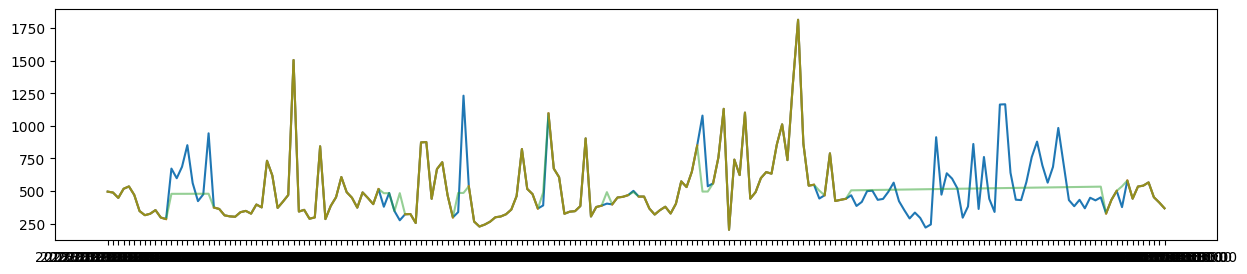

223.17311571477677


In [344]:
fig, ax = fig_ax()
ax.plot(data_train[serie][100:300], alpha=1)
ax.plot(TS_missing[serie][100:300])
ax.plot(holed_series_interpolated.iloc[100:300].values+mean.values, alpha=0.5)
plt.show()
missing_idx = np.isnan(TS_missing[serie].values)
mae = mean_absolute_error(data_train[serie].values[missing_idx], holed_series_interpolated[serie].values[missing_idx]+mean.values)
print(mae)

In [345]:
serie_list_interp = []

for serie in tqdm(test_series):
    y = TS_missing.loc[:,[serie]].copy()
    mean = y.mean()
    y = y - mean
    # ts_interpolated = var_based_interpolation(y, feature_pca, lag_order=int(1*longest_missing_segment(y))).values
    ts_interpolated = y.apply(lambda col: loess_interpolation(col, detect_missing_sequences(col)))
    ts_interpolated += mean.values  
    serie_list_interp.append(ts_interpolated)
print(f"Il reste {np.isnan(serie_list_interp).sum()} NaN")    

100%|██████████| 200/200 [00:06<00:00, 28.82it/s]

Il reste 0 NaN


In [347]:
serie_list_interp = np.array(serie_list_interp).squeeze()
missing_idx = np.isnan(TS_missing[test_series].values)
mae = mean_absolute_error(data_train[test_series].values[missing_idx], serie_list_interp.T[missing_idx])
print(mae)

106.63159990115156


In [348]:
mae_list = []
num_list = []
seq_count_list = []
for i in range(1,300):
    try:
        filtered_tab = filter_true_sequences(missing_idx, i)
        mae = mean_absolute_error(data_train[test_series].values[filtered_tab], serie_list_VAR.T[filtered_tab])
        
        # Compter le nombre de séquences valides conservées
        seq_count = sum(
            1 for j in range(filtered_tab.shape[1]) 
            if len(np.where(filtered_tab[:, j])[0]) == i
        )
        
        mae_list.append(mae)
        num_list.append(i)
        seq_count_list.append(seq_count)
    except:
        pass

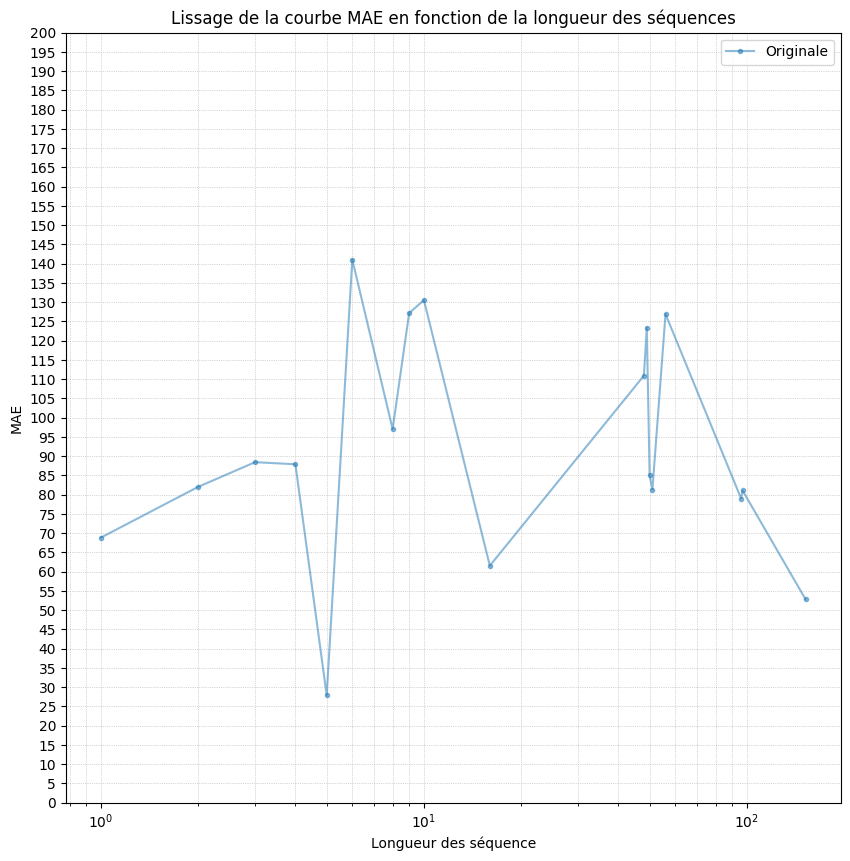

In [349]:
# Appliquer un filtre gaussien pour lisser la courbe
smoothed_mae = gaussian_filter1d(mae_list, sigma=2)

# Tracer la courbe originale et lissée
plt.figure(figsize=(10, 10))
plt.plot(num_list, mae_list, label="Originale", alpha=0.5, marker=".")
# plt.plot(num_list, smoothed_mae, label="Lissée (Gaussien)", linewidth=2)

# Ajout des labels et du titre
plt.xlabel("Longueur des séquence")
plt.ylabel("MAE")
plt.title("Lissage de la courbe MAE en fonction de la longueur des séquences")
plt.legend()
plt.ylim((0,200))
# Échelle logarithmique pour l'axe X
plt.xscale('log')

# Ajouter plus de graduations sur l'axe Y
ax = plt.gca()  # Récupérer l'axe courant
ax.yaxis.set_major_locator(ticker.MultipleLocator(5))  # Graduation principale tous les 2
# ax.yaxis.set_minor_locator(ticker.MultipleLocator(0))  # Graduation mineure tous les 1
ax.grid(which='both', linestyle=':', linewidth=0.5)  # Ajouter une grille pour plus de clarté
plt.savefig('plots_raport/VAR_Analysis_mixed.png', dpi=500)

plt.show()



## Mini XGBoost

In [357]:
from xgboost import XGBRegressor

def miniXG(holed_series):
    # Créer un dataset avec des trous artificiels
    X_train = holed_series.dropna().shift(1).fillna(0)  # Feature: valeur précédente
    y_train = holed_series.dropna()  # Target: vraie valeur

    xgb_model = XGBRegressor(n_estimators=20, max_depth=5, learning_rate=0.1)
    xgb_model.fit(X_train, y_train)
    
    for col in holed_series.columns:
        missing_sequences = detect_missing_sequences(holed_series[col])
        for start_idx, num_missing in missing_sequences:
            if num_missing <= 2:  # Très courtes séquences
                missing_range = holed_series[col].loc[start_idx:].index[:num_missing]
                X_pred = holed_series_interpolated.loc[missing_range].shift(1).fillna(0)
                correction = xgb_model.predict(X_pred)
                holed_series_interpolated.loc[missing_range, col] = correction
    return holed_series_interpolated

In [358]:
serie = "holed_8"
y = TS_missing.loc[:,[serie]].copy()
mean = y.mean()
y = y - mean
holed_series_interpolated = miniXG(y.copy())

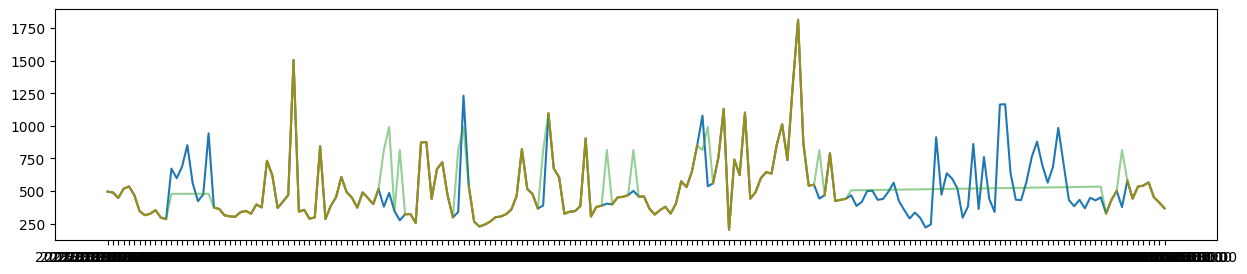

258.02417869046485


In [359]:
fig, ax = fig_ax()
ax.plot(data_train[serie][100:300], alpha=1)
ax.plot(TS_missing[serie][100:300])
ax.plot(holed_series_interpolated.iloc[100:300].values+mean.values, alpha=0.5)
plt.show()
missing_idx = np.isnan(TS_missing[serie].values)
mae = mean_absolute_error(data_train[serie].values[missing_idx], holed_series_interpolated[serie].values[missing_idx]+mean.values)
print(mae)

## Volatility based interpolation

In [380]:
import time

In [391]:
def volatility_based_interp(holed_series):
    
    volatility = holed_series.rolling(window=5).std()  # Calcul de la volatilité locale
    high_volatility = volatility > volatility.median()  # Seuil pour différencier haute/basse volatilité

    holed_series_interpolated = holed_series.copy()
    for col in holed_series.columns:
        missing_sequences = detect_missing_sequences(holed_series[col])
        for start_idx, num_missing in missing_sequences:
            if num_missing <= 2:  # Très courtes séquences
                missing_range = holed_series[col].loc[start_idx:].index[:num_missing]

                if high_volatility[col].loc[start_idx]:  # Si volatilité haute
                    holed_series_interpolated.loc[missing_range, col] = holed_series[col].rolling(window=3, center=True).median()
                else:  # Si volatilité basse
                    temp = holed_series_interpolated.index
                    holed_series.index = pd.to_datetime(holed_series.index)
                    holed_series_interpolated.loc[missing_range, col] = holed_series[col].interpolate(method="spline", order=1)
                    holed_series.index = temp
            else:
                missing_range = holed_series[col].loc[start_idx:].index[:num_missing]
                holed_series_interpolated.loc[missing_range, col] = holed_series_interpolated.interpolate(method="linear", limit_direction="both", axis=0).loc[missing_range, col]
                
    return holed_series_interpolated

In [392]:
serie = "holed_8"
y = TS_missing.loc[:,[serie]].copy()
mean = y.mean()
y = y - mean
holed_series_interpolated = volatility_based_interp(y.copy())

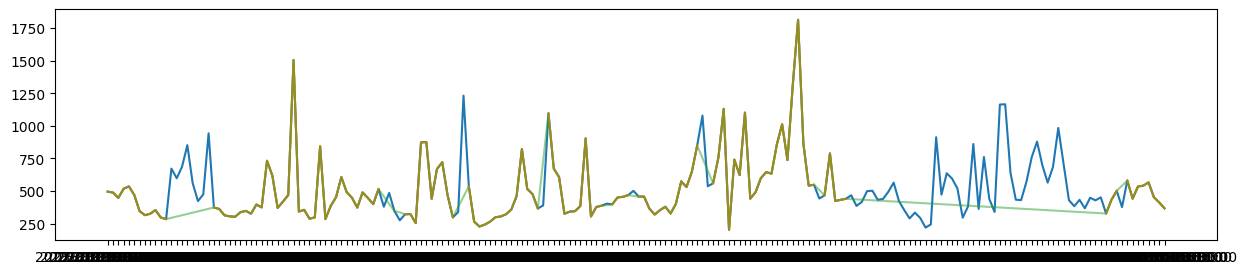

201.03493540687498


In [393]:
fig, ax = fig_ax()
ax.plot(data_train[serie][100:300], alpha=1)
ax.plot(TS_missing[serie][100:300])
ax.plot(holed_series_interpolated.iloc[100:300].values+mean.values, alpha=0.5)
plt.show()
missing_idx = np.isnan(TS_missing[serie].values)
mae = mean_absolute_error(data_train[serie].values[missing_idx], holed_series_interpolated[serie].values[missing_idx]+mean.values)
print(mae)

## EWMA

In [77]:
import numpy as np
import pandas as pd

def ewma(holed_series):
    holed_series_interpolated = holed_series.copy()

    # ⚠ Assurer que l'index est bien en datetime64
    holed_series_interpolated.index = pd.to_datetime(holed_series_interpolated.index, errors="coerce")

    for col in holed_series.columns:
        missing_sequences = detect_missing_sequences(holed_series[col])

        for start_idx, num_missing in missing_sequences:
            # Correction : Sélection avec .iloc[] pour éviter les erreurs d'indexation
            if start_idx + num_missing < len(holed_series_interpolated):
                missing_range = holed_series_interpolated.iloc[start_idx : start_idx + num_missing].index
            else:
                missing_range = holed_series_interpolated.iloc[start_idx:].index

            if num_missing <= 2:  # Seulement pour les trous très courts
                before = holed_series_interpolated[col].shift(1).loc[missing_range].ffill()
                after = holed_series_interpolated[col].shift(-1).loc[missing_range].bfill()

                # Vérification si NaN persistants
                if np.isnan(before).any() or np.isnan(after).any():
                    print(f"❌ NaN détecté sur {missing_range}")

                # Moyenne pondérée temporelle
                holed_series_interpolated.loc[missing_range, col] = (0.7 * before + 0.3 * after)

            else:
                holed_series_interpolated.loc[missing_range, col] = holed_series_interpolated.interpolate(
                    method="linear", limit_direction="both", axis=0
                ).loc[missing_range, col]

    return holed_series_interpolated


In [78]:
serie = "holed_8"
y = TS_missing.loc[:,[serie]].copy()
mean = y.mean()
y = y - mean
holed_series_interpolated = ewma(y.copy())

TypeError: can only concatenate str (not "int") to str

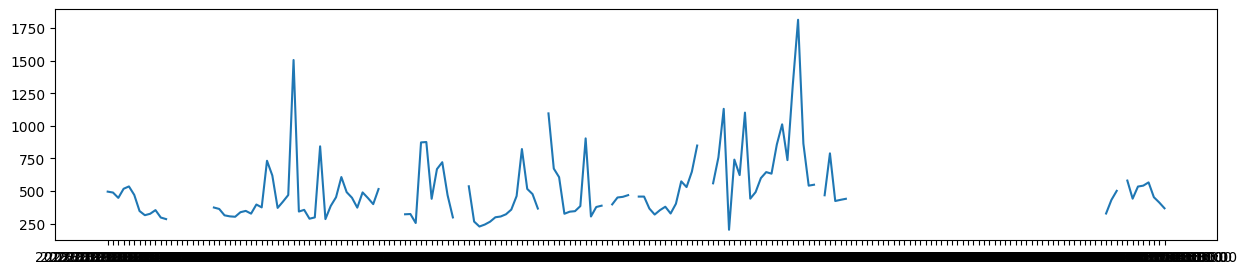

205.7532863145258


In [436]:
fig, ax = fig_ax()
# ax.plot(data_train[serie][100:300], alpha=1)
ax.plot(TS_missing[serie][100:300])
# ax.plot(holed_series_interpolated.iloc[100:300].values+mean.values, alpha=0.5)
plt.show()
missing_idx = np.isnan(TS_missing[serie].values)
mae = mean_absolute_error(data_train[serie].values[missing_idx], holed_series_interpolated[serie].values[missing_idx]+mean.values)
print(mae)

In [426]:
serie_list_interp = []

for serie in tqdm(test_series):
    y = TS_missing.loc[:,[serie]].copy()
    mean = y.mean()
    y = y - mean
    # ts_interpolated = var_based_interpolation(y, feature_pca, lag_order=int(1*longest_missing_segment(y))).values
    ts_interpolated = ewma(y.copy())
    ts_interpolated += mean.values  
    serie_list_interp.append(ts_interpolated)
print(f"Il reste {np.isnan(serie_list_interp).sum()} NaN")    

  0%|          | 0/200 [00:00<?, ?it/s]

 24%|██▍       | 49/200 [00:01<00:05, 29.04it/s]

❌ NaN détecté sur Index(['2023-01-09 00:00:00'], dtype='object', name='Horodate')


 30%|███       | 61/200 [00:02<00:05, 26.69it/s]

❌ NaN détecté sur Index(['2023-01-09 00:00:00'], dtype='object', name='Horodate')
❌ NaN détecté sur Index(['2023-01-09 00:00:00'], dtype='object', name='Horodate')
❌ NaN détecté sur Index(['2023-01-09 00:00:00'], dtype='object', name='Horodate')


 41%|████      | 82/200 [00:03<00:04, 27.31it/s]

❌ NaN détecté sur Index(['2023-01-09 00:00:00'], dtype='object', name='Horodate')


 53%|█████▎    | 106/200 [00:03<00:03, 26.42it/s]

❌ NaN détecté sur Index(['2023-01-09 00:00:00'], dtype='object', name='Horodate')


 64%|██████▎   | 127/200 [00:04<00:02, 26.15it/s]

❌ NaN détecté sur Index(['2023-01-09 00:00:00'], dtype='object', name='Horodate')


 70%|██████▉   | 139/200 [00:05<00:02, 26.69it/s]

❌ NaN détecté sur Index(['2023-01-09 00:00:00'], dtype='object', name='Horodate')
❌ NaN détecté sur Index(['2023-01-31 00:00:00'], dtype='object', name='Horodate')


 76%|███████▌  | 151/200 [00:05<00:01, 26.72it/s]

❌ NaN détecté sur Index(['2023-01-31 00:00:00'], dtype='object', name='Horodate')


 80%|████████  | 160/200 [00:06<00:01, 26.27it/s]

❌ NaN détecté sur Index(['2023-01-31 00:00:00'], dtype='object', name='Horodate')


 88%|████████▊ | 175/200 [00:06<00:00, 26.32it/s]

❌ NaN détecté sur Index(['2023-01-09 00:00:00'], dtype='object', name='Horodate')


 90%|█████████ | 181/200 [00:06<00:00, 25.69it/s]

❌ NaN détecté sur Index(['2023-01-09 00:00:00'], dtype='object', name='Horodate')
❌ NaN détecté sur Index(['2023-01-09 00:00:00'], dtype='object', name='Horodate')


 98%|█████████▊| 197/200 [00:07<00:00, 26.85it/s]

❌ NaN détecté sur Index(['2023-01-09 00:00:00'], dtype='object', name='Horodate')


100%|██████████| 200/200 [00:07<00:00, 26.60it/s]

Il reste 15 NaN


In [424]:
serie_list_interp = np.array(serie_list_interp).squeeze()
missing_idx = np.isnan(TS_missing[test_series].values)
mae = mean_absolute_error(data_train[test_series].values[missing_idx], serie_list_interp.T[missing_idx])
print(mae)

ValueError: Input contains NaN.

In [437]:
TS_missing.head()

,holed_1,holed_2,holed_3,holed_4,holed_5,holed_6,holed_7,holed_8,holed_9,holed_10,...,holed_991,holed_992,holed_993,holed_994,holed_995,holed_996,holed_997,holed_998,holed_999,holed_1000
Horodate,,,,,,,,,,,,,,,,,,,,,
2023-01-09 00:00:00,578.0,698.0,NaN,2.0,283.0,154.0,131.0,619.0,107.0,466.0,...,0.0,32.0,152.0,NaN,0.0,1099.0,117.0,45.0,253.0,186.0
2023-01-09 00:30:00,533.0,224.0,18.0,2.0,1047.0,150.0,106.0,542.0,114.0,NaN,...,0.0,34.0,84.0,NaN,NaN,782.0,109.0,40.0,227.0,180.0
2023-01-09 01:00:00,623.0,246.0,17.0,NaN,1185.0,131.0,74.0,517.0,109.0,547.0,...,0.0,30.0,24.0,NaN,0.0,630.0,375.0,58.0,237.0,166.0
2023-01-09 01:30:00,613.0,643.0,17.0,18.0,746.0,77.0,146.0,455.0,NaN,390.0,...,0.0,34.0,24.0,NaN,0.0,773.0,468.0,48.0,245.0,525.0
2023-01-09 02:00:00,1823.0,318.0,18.0,15.0,560.0,125.0,82.0,551.0,104.0,534.0,...,0.0,30.0,46.0,NaN,0.0,879.0,534.0,41.0,175.0,372.0


## Ridge

In [49]:
import numpy as np
import pandas as pd
from sklearn.linear_model import Ridge

def ridge_interpolation(holed_series, window_size=3, alpha=0.5):
    """
    Interpolation des courtes séquences manquantes via une régression Ridge locale.
    
    Arguments:
    - holed_series : pandas Series (index en datetime), la série temporelle avec des trous.
    - window_size : int, nombre de points avant et après la séquence manquante à utiliser.
    - alpha : float, coefficient de régularisation pour Ridge.

    Retourne:
    - holed_series_interpolated : pandas Series avec valeurs manquantes interpolées.
    """

    holed_series_interpolated = holed_series.copy()
    
    # ⚠️ S'assurer que l'index est bien en datetime64
    holed_series_interpolated.index = pd.to_datetime(holed_series_interpolated.index)

    missing_sequences = detect_missing_sequences(holed_series)

    for start_idx, num_missing in missing_sequences:
        missing_range = holed_series.loc[start_idx:].index[:num_missing]

        if num_missing > 2:  
            # Fallback sur interpolation linéaire pour les séquences plus longues
            # holed_series_interpolated.loc[missing_range] = holed_series.interpolate(
            #     method="linear", limit_direction="both"
            # ).loc[missing_range]
            continue
        else:
            # 📌 Sélection des indices des valeurs connues autour du trou
            before_idx = holed_series.loc[:start_idx].dropna().index[-window_size:]
            after_idx = holed_series.loc[start_idx:].dropna().index[:window_size]
            known_idx = before_idx.union(after_idx)

            # 🛑 Si pas assez de valeurs connues, fallback sur interpolation linéaire
            if len(known_idx) < 3:
                holed_series_interpolated.loc[missing_range] = holed_series.interpolate(
                    method="linear", limit_direction="both"
                ).loc[missing_range]
                continue

            # 🔹 Conversion correcte des timestamps en int64
            known_x = known_idx.astype('datetime64[ns]').view(np.int64).reshape(-1, 1)
            known_y = holed_series.loc[known_idx].values

            missing_x = missing_range.astype('datetime64[ns]').view(np.int64).reshape(-1, 1)

            # 🔹 Entraînement du modèle Ridge
            model = Ridge(alpha=alpha)
            model.fit(known_x, known_y)

            # 🔹 Prédiction des valeurs manquantes
            predicted_values = model.predict(missing_x)

            # 🔹 Remplissage des trous
            holed_series_interpolated.loc[missing_range] = predicted_values

    return holed_series_interpolated


In [50]:
serie = "holed_8"
y = TS_missing.loc[:,serie].copy()
mean = y.mean()
y = y - mean
holed_series_interpolated = ridge_interpolation(y.copy())
holed_series_interpolated = holed_series_interpolated.interpolate(method="linear", limit_direction="both")

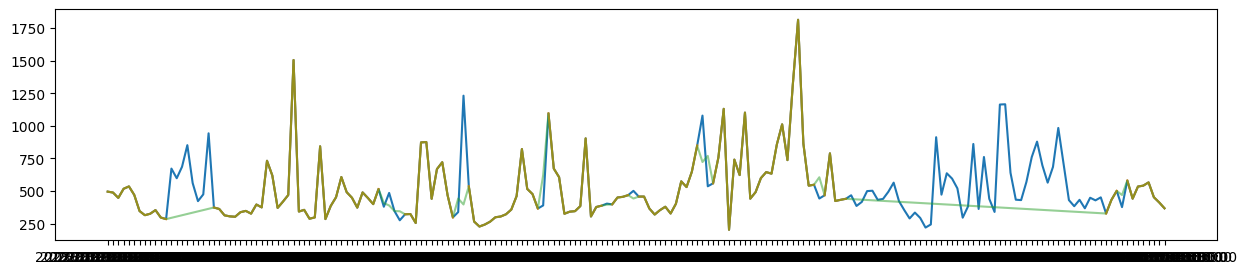

230.02729848174485


In [51]:
fig, ax = fig_ax()
ax.plot(data_train[serie][100:300], alpha=1)
ax.plot(TS_missing[serie][100:300])
ax.plot(holed_series_interpolated.iloc[100:300].values+mean, alpha=0.5)
plt.show()
missing_idx = np.isnan(TS_missing[serie].values)
mae = mean_absolute_error(data_train[serie].values[missing_idx], holed_series_interpolated.values[missing_idx]+mean)
print(mae)

## Prophet

In [23]:
import pandas as pd
import numpy as np
from prophet import Prophet
import pandas as pd

def ph(holed_series, pca_series):
    """
    Interpolation des valeurs manquantes avec Prophet en utilisant des variables exogènes.

    Arguments :
    - holed_series : pandas Series, la série temporelle avec des trous (index en datetime).
    - pca_series : pandas DataFrame, séries exogènes obtenues par PCA.

    Retourne :
    - holed_series_interpolated : pandas Series avec valeurs interpolées.
    """

    holed_series_interpolated = holed_series.copy()

    # ✅ Assurer que l'index est bien en datetime
    holed_series_interpolated.index = pd.to_datetime(holed_series_interpolated.index)
    pca_series.index = pd.to_datetime(pca_series.index)

    # 🔹 Création du DataFrame pour Prophet
    df = holed_series_interpolated.reset_index().rename(columns={'Horodate': 'ds', holed_series_interpolated.name: 'y'}).copy()

    # 🔹 Ajout des features exogènes (PCA)
    df = df.merge(pca_series, left_on='ds', right_index=True, how='left')

    # 🔹 Initialiser Prophet avec régression sur les variables exogènes
    model = Prophet()
    for col in pca_series.columns:
        model.add_regressor(col)

    # 🔹 Entraîner Prophet uniquement sur les valeurs connues
    train_df = df.dropna()
    model.fit(train_df)

    # 🔹 Préparer toutes les dates pour la prédiction
    future = df[['ds'] + list(pca_series.columns)]  # Garder les mêmes dates et exogènes

    # 🔹 Prédire les valeurs
    forecast = model.predict(future)

    # 🔹 Remplir les valeurs NaN uniquement avec les prédictions de Prophet
    df['y_filled'] = df['y'].combine_first(forecast['yhat'])

    # 🔹 Remettre l'index en datetime
    holed_series_interpolated.loc[df['ds']] = df['y_filled'].values

    return holed_series_interpolated


In [24]:
serie = "holed_8"
y = TS_missing.loc[:,serie].copy()
mean = y.mean()
y = y - mean
holed_series_interpolated = ph(y,feature_pca)

21:18:18 - cmdstanpy - INFO - Chain [1] start processing
21:18:19 - cmdstanpy - INFO - Chain [1] done processing


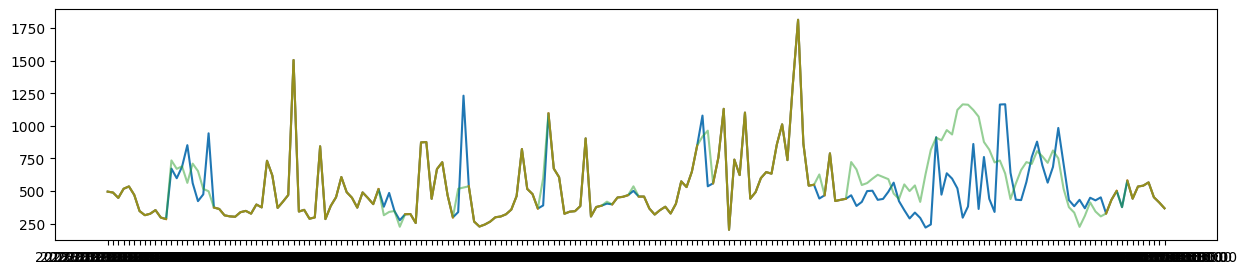

222.04488314050892


In [31]:
fig, ax = fig_ax()
ax.plot(data_train[serie][100:300], alpha=1)
ax.plot(TS_missing[serie][100:300])
ax.plot(holed_series_interpolated.iloc[100:300].values+mean, alpha=0.5)
plt.show()
missing_idx = np.isnan(TS_missing[serie].values)
mae = mean_absolute_error(data_train[serie].values[missing_idx], holed_series_interpolated.values[missing_idx]+mean)
print(mae)

In [33]:
serie_list_interp = []

for serie in tqdm(test_series):
    y = TS_missing.loc[:,serie]
    mean = y.mean()
    y = y - mean
    # ts_interpolated = var_based_interpolation(y, feature_pca, lag_order=int(1*longest_missing_segment(y))).values
    ts_interpolated = ph(y,feature_pca)
    ts_interpolated += mean  
    serie_list_interp.append(ts_interpolated)
print(f"Il reste {np.isnan(serie_list_interp).sum()} NaN")    

  0%|          | 0/200 [00:00<?, ?it/s]21:21:30 - cmdstanpy - INFO - Chain [1] start processing
21:21:30 - cmdstanpy - INFO - Chain [1] done processing
  1%|          | 2/200 [00:01<01:49,  1.80it/s]21:21:31 - cmdstanpy - INFO - Chain [1] start processing
21:21:31 - cmdstanpy - INFO - Chain [1] done processing
  2%|▏         | 3/200 [00:01<01:48,  1.81it/s]21:21:31 - cmdstanpy - INFO - Chain [1] start processing
21:21:31 - cmdstanpy - INFO - Chain [1] done processing
  2%|▏         | 4/200 [00:02<01:49,  1.79it/s]21:21:32 - cmdstanpy - INFO - Chain [1] start processing
21:21:32 - cmdstanpy - INFO - Chain [1] done processing
  2%|▎         | 5/200 [00:02<01:49,  1.78it/s]21:21:33 - cmdstanpy - INFO - Chain [1] start processing
21:21:33 - cmdstanpy - INFO - Chain [1] done processing
  3%|▎         | 6/200 [00:03<01:38,  1.97it/s]21:21:33 - cmdstanpy - INFO - Chain [1] start processing
21:21:33 - cmdstanpy - INFO - Chain [1] done processing
  4%|▎         | 7/200 [00:03<01:30,  2.13it/s]2

Il reste 0 NaN


In [35]:
serie_list_interp = np.array(serie_list_interp).squeeze()
missing_idx = np.isnan(TS_missing[test_series].values)
mae = mean_absolute_error(data_train[test_series].values[missing_idx], serie_list_interp.T[missing_idx])
print(mae)

94.61966064542109


In [49]:
def filter_true_sequences(arr: np.ndarray, min_length: int) -> np.ndarray:
    """
    Conserve uniquement les séquences de True d'une longueur donnée dans un tableau numpy 2D,
    en remplaçant les autres valeurs par False. La vérification se fait uniquement sur les colonnes.
    
    :param arr: np.ndarray booléen 2D contenant des True et False
    :param min_length: Longueur minimale des séquences de True à conserver
    :return: Nouveau tableau avec uniquement les séquences valides conservées
    """
    result = np.zeros_like(arr, dtype=bool)
    
    # Parcours des colonnes
    for j in range(arr.shape[1]):
        true_indices = np.where(arr[:, j])[0]  # Indices des True
        if len(true_indices) > 0:
            splits = np.split(true_indices, np.where(np.diff(true_indices) != 1)[0] + 1)  # Séquences continues
            for seq in splits:
                if len(seq) == min_length:
                    result[seq, j] = True
    
    return result

mae_list = []
num_list = []
seq_count_list = []
for i in range(1,300):
    try:
        filtered_tab = filter_true_sequences(missing_idx, i)
        mae = mean_absolute_error(data_train[test_series].values[filtered_tab], serie_list_interp.T[filtered_tab])
        
        # Compter le nombre de séquences valides conservées
        seq_count = sum(
            1 for j in range(filtered_tab.shape[1]) 
            if len(np.where(filtered_tab[:, j])[0]) == i
        )
        
        mae_list.append(mae)
        num_list.append(i)
        seq_count_list.append(seq_count)
    except:
        pass

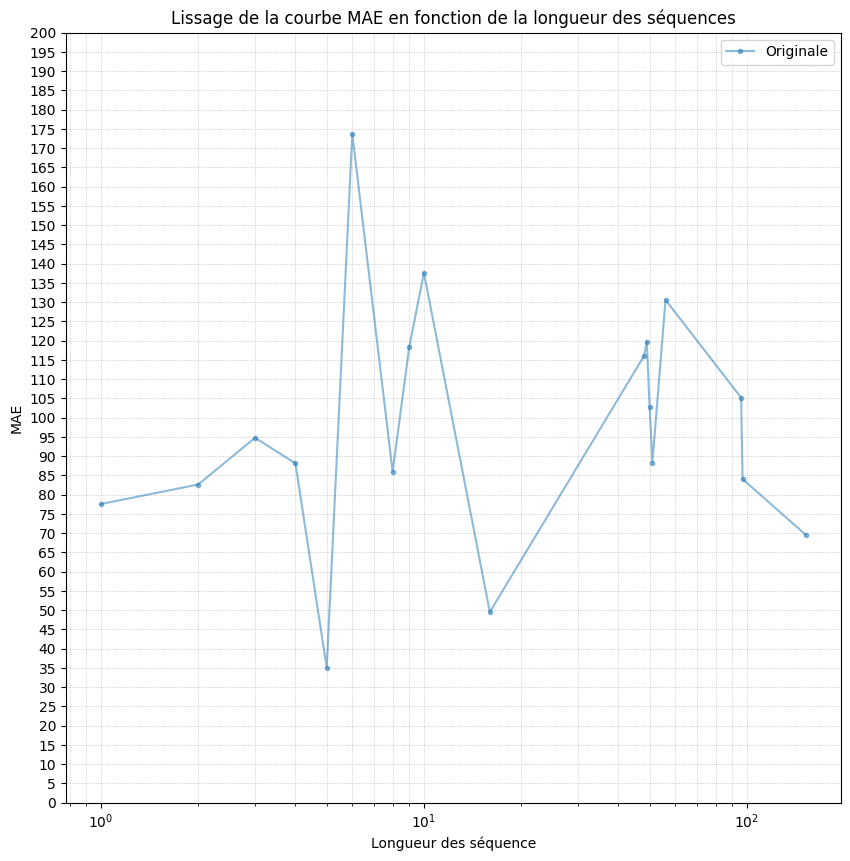

In [50]:
# Appliquer un filtre gaussien pour lisser la courbe
smoothed_mae = gaussian_filter1d(mae_list, sigma=2)

# Tracer la courbe originale et lissée
plt.figure(figsize=(10, 10))
plt.plot(num_list, mae_list, label="Originale", alpha=0.5, marker=".")
# plt.plot(num_list, smoothed_mae, label="Lissée (Gaussien)", linewidth=2)

# Ajout des labels et du titre
plt.xlabel("Longueur des séquence")
plt.ylabel("MAE")
plt.title("Lissage de la courbe MAE en fonction de la longueur des séquences")
plt.legend()
plt.ylim((0,200))
# Échelle logarithmique pour l'axe X
plt.xscale('log')

# Ajouter plus de graduations sur l'axe Y
ax = plt.gca()  # Récupérer l'axe courant
ax.yaxis.set_major_locator(ticker.MultipleLocator(5))  # Graduation principale tous les 2
# ax.yaxis.set_minor_locator(ticker.MultipleLocator(0))  # Graduation mineure tous les 1
ax.grid(which='both', linestyle=':', linewidth=0.5)  # Ajouter une grille pour plus de clarté
plt.savefig('plots_raport/VAR_Analysis_mixed.png', dpi=500)

plt.show()

In [685]:
import numpy as np
import pandas as pd
from sklearn.impute import KNNImputer

def knn_linear_interpolation(holed_series, n_neighbors=5, short_seq_threshold=3):
    """
    Remplit les valeurs manquantes dans une série temporelle en utilisant :
    - `KNNImputer` pour les séquences courtes de valeurs manquantes.
    - `Interpolation linéaire` pour les séquences longues.

    Paramètres :
    - holed_series : pandas Series, série temporelle avec des NaN.
    - n_neighbors : int, nombre de voisins utilisés pour KNN.
    - short_seq_threshold : int, taille maximale d'un trou pour appliquer KNN.

    Retourne :
    - holed_series_interpolated : pandas Series avec les valeurs complétées.
    """

    holed_series_interpolated = holed_series.copy()

    # Détection des séquences de valeurs manquantes
    missing_sequences = detect_missing_sequences(holed_series)

    # Appliquer KNN sur les séquences courtes
    short_missing_idx = []
    for start_idx, num_missing in missing_sequences:
        if num_missing <= short_seq_threshold:  # KNN seulement sur les trous courts
            short_missing_idx.extend(holed_series.loc[start_idx:].index[:num_missing])

    # Appliquer l'interpolation linéaire sur les séquences longues
    holed_series_interpolated = holed_series.interpolate(method="linear", limit_direction="both")

    if short_missing_idx:
        # Préparer les données pour KNNImputer
        knn_data = holed_series_interpolated.copy().to_frame()  # Convertir en DataFrame
        imputer = KNNImputer(n_neighbors=n_neighbors, weights="distance")
        knn_filled = imputer.fit_transform(knn_data)

        # Appliquer les valeurs KNN uniquement sur les trous courts
        knn_filled_series = pd.Series(knn_filled.flatten(), index=holed_series.index)
        holed_series_interpolated.loc[short_missing_idx] = knn_filled_series.loc[short_missing_idx]

    return holed_series_interpolated


In [ ]:
serie = "holed_8"
y = TS_missing.loc[:,serie].copy()
mean = y.mean()
y = y - mean
holed_series_interpolated = knn_linear_interpolation(y,feature_pca)

# Model Rankings

| Méthode                     | Score / MAE |
|-----------------------------|------------:|
| **XGBOOST_PCA**             | 104    |
| **Benchmark**               | 116.1044    |
| **A battre**                | 92.8029     |
| **Interpolation Cubique**    | 29038  |
| **Interpolation Spline**     | 29038  |
| **Interpolation Linéaire**   | 107.7838   |
| **Low Rank Adaptation**      | 193.39  |
| **AR interpolation**      | 312 |
| **VAR interpolation (1)**      | 102 |
